# ENCS5343 Computer Vision : Handwriting Identification using Deep Neural Networks

# Configuration

In [1]:
batch_size = 64
num_workers = 6
images_dir = "./isolated_words_per_user"
split = [0.7, 0.15, 0.15]
max_epochs = 500
learning_rate = 0.001
patience = 50
min_delta = 0.0001

# Preparation

### Libaries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.callbacks import EarlyStopping
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchmetrics.classification import Accuracy
import os
from pytorch_lightning.callbacks import ModelCheckpoint, Callback

torch.set_float32_matmul_precision('medium')
seed = 42
torch.manual_seed(seed)
checkpoint_dir = 'checkpoints/'
# Create checkpoint directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

### Loading Images + Split

In [3]:
dataset = datasets.ImageFolder(root=images_dir)
num_classes = len(dataset.classes)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, split)


base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5),
])


train_dataset.dataset.transform = base
val_dataset.dataset.transform = base
test_dataset.dataset.transform = base

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True)


In [4]:
# To verfiy the transfomrations
def show_images_in_grid(dataloader, num_images=9):
    images, labels = next(iter(dataloader))
    grid_img = torchvision.utils.make_grid(images[:num_images], nrow=3)
    np_grid_img = grid_img.numpy().transpose((1, 2, 0))
    np_grid_img = np.clip(np_grid_img, 0, 1)
    # Display the grid
    plt.figure(figsize=(8, 8))
    plt.imshow(np_grid_img)
    plt.axis('off')
    plt.show()


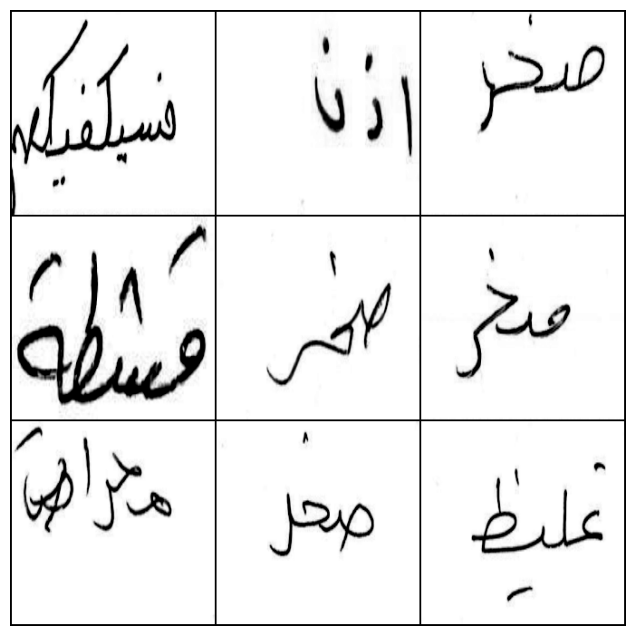

In [5]:
show_images_in_grid(train_loader)

### Metric Logger
A callback that saves loss/accuracy.

In [6]:
class MetricsLogger(Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.val_accuracy = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Log the average training loss for the epoch
        epoch_loss = trainer.callback_metrics.get("train_loss", None)
        if epoch_loss is not None:
            self.train_loss.append(epoch_loss.item())
        

    def on_validation_epoch_end(self, trainer, pl_module):
        # Log the average validation loss and accuracy for the epoch
        val_loss = trainer.callback_metrics.get("val_loss", None)
        val_accuracy = trainer.callback_metrics.get("val_acc", None)

        if val_loss is not None:
            self.val_loss.append(val_loss.item())
        if val_accuracy is not None:
            self.val_accuracy.append(val_accuracy.item())

### BaseCNN
A class that implements everything a CNN needs, except the archtecture. To use, inherit and implement init() and forward() methods.

In [7]:
from torchmetrics.classification import Accuracy
from torch.optim.lr_scheduler import ReduceLROnPlateau

class BaseCNN(pl.LightningModule):
    def __init__(self, model, num_classes, learning_rate=1e-3):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.loss_fn = nn.CrossEntropyLoss()
        self.num_classes = num_classes
        self.accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_acc", acc)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        return loss


    def configure_optimizers(self):
        # Optimizer: AdamW for efficient optimization
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=1e-4  # Regularization to reduce overfitting
        )

        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, 
            T_0=10,  # Number of iterations for the first restart
            T_mult=2,  # Multiplicative factor for increasing restart cycle
            eta_min=1e-6  # Minimum learning rate
        )
        return [optimizer], [{"scheduler": scheduler, "monitor": "val_loss", "interval": "epoch"}]

Training Function that uses the above classes

In [8]:
def train_model(model, train_loader, val_loader, max_epochs=200, checkpoint_dir='checkpoints/', early_stopping_patience=15):
    # Create the ModelCheckpoint callback to save the best model based on validation loss
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss", 
        dirpath=checkpoint_dir, 
        filename="best-model", 
        save_top_k=1, 
        mode="min", 
        verbose=True
    )

    # Create EarlyStopping callback
    early_stopping_callback = EarlyStopping(
        monitor="val_loss", 
        patience=early_stopping_patience,
        min_delta=0.001,
        verbose=True, 
        mode="min"
    )

    metrics_logger = MetricsLogger()
    # Create the trainer
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        callbacks=[checkpoint_callback, early_stopping_callback, metrics_logger],
        accelerator="auto"
    )

    # Train the model
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # Return the trained model
    return model, trainer, metrics_logger

### Save metrics_logger output in a convenient df

In [9]:
results_df = pd.DataFrame(columns=['Model', 'Train Loss List', 'Validation Loss List', 'Validation Accuracy List', 'Train Accuracy', 'Validation Accuracy','Test Accuracy', 'Augmented'])


### Functions To Add Training and Evaluation Results to the Glogal Data Frame, and Plotting Both Th Accuracy and Loss Vs. #of Epochs

In [10]:

def add_results(model, trainer: pl.Trainer, metrics_logger, train_loader, val_loader, test_loader, augmented):
    # Load the best model based on validation loss
    best_model = model.__class__.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test the model on the test set
    train_results = trainer.test(best_model, dataloaders=[train_loader])
    val_results = trainer.test(best_model, dataloaders=[val_loader])
    test_results = trainer.test(best_model, dataloaders=[test_loader])

    # Get the test accuracy from the test results
    train_accuracy = train_results[0]["test_acc"]
    test_accuracy = test_results[0]["test_acc"]
    val_accuracy = val_results[0]["test_acc"]
    # Log the results
    results_df.loc[len(results_df)] = {
        "Model": model.__class__.__name__,
        "Train Loss List": metrics_logger.train_loss,
        "Validation Loss List": metrics_logger.val_loss,
        "Validation Accuracy List": metrics_logger.val_accuracy,
        "Train Accuracy": train_accuracy,
        "Validation Accuracy": val_accuracy,
        "Test Accuracy": test_accuracy,
        "Augmented": augmented
    }
    torch.cuda.empty_cache()
    return results_df

# plot the list from results df for all models (each type on a separate subfigure). Make it a separate function
def plot_results(results_df):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot the training and validation loss
    for i, row in results_df.iterrows():
        axs[0].plot(row["Train Loss List"], label=f"{row['Model']}, augmented {row['Augmented']} Train Loss")
        axs[0].plot(row["Validation Loss List"], label=f"{row['Model']}, augmented {row['Augmented']} Validation Loss")
    axs[0].set_title("Training and Validation Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    # Plot the validation accuracy
    for i, row in results_df.iterrows():
        axs[1].plot(row["Validation Accuracy List"], label=f"{row['Model']}, augmented {row['Augmented']} Validation Accuracy")
    axs[1].set_title("Validation Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

### Function to Get Best Validation Accuracy, Best Validation Loss, and Epoch Number there was

In [11]:
def print_val_accuracy_loss_epoch(df):
    best_accuracy = df['Validation Accuracy'][df.index[-1]]
    for index, row in df.iterrows():
        if row['Validation Accuracy'] == best_accuracy:
            val_acc_list = row['Validation Accuracy List']
            val_loss_list = row['Validation Loss List']
            epoch_index = val_acc_list.index(best_accuracy)
            val_loss = val_loss_list[epoch_index]
    print(f"Best Validation Accuracy: {best_accuracy:.4f} at epoch {epoch_index + 1}, Validation Loss: {val_loss:.4f}")

# Task 1: Build Custom CNN (CNN without augmentation)

## CNN 1

In [12]:
class CNN1(BaseCNN):
    def __init__(self, num_classes, learning_rate):
        super().__init__(learning_rate, num_classes=num_classes)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Reduces spatial size by 2x
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Additional downsampling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Reduces to 1x1 feature map
        self.fc1 = nn.Linear(64, 256)  # Compact fully connected layer
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)  # Flatten for the FC layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNN1(num_classes, learning_rate=learning_rate)
model, trainer, metrics_logger = train_model(model, train_loader, val_loader, max_epochs=max_epochs, early_stopping_patience=patience)
results_df = add_results(model, trainer, metrics_logger, train_loader, val_loader, test_loader, augmented='no')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\User\Documents\BZU\Vision\Final_Project\c

Epoch 0: 100%|██████████| 90/90 [00:02<00:00, 34.03it/s, v_num=22]         

Metric val_loss improved. New best score: 4.120
Epoch 0, global step 90: 'val_loss' reached 4.11961 (best 4.11961), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 1: 100%|██████████| 90/90 [00:02<00:00, 35.68it/s, v_num=22]

Metric val_loss improved by 0.204 >= min_delta = 0.001. New best score: 3.916
Epoch 1, global step 180: 'val_loss' reached 3.91600 (best 3.91600), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 2: 100%|██████████| 90/90 [00:02<00:00, 35.69it/s, v_num=22]

Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 3.877
Epoch 2, global step 270: 'val_loss' reached 3.87712 (best 3.87712), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 3: 100%|██████████| 90/90 [00:02<00:00, 35.70it/s, v_num=22]

Metric val_loss improved by 0.036 >= min_delta = 0.001. New best score: 3.841
Epoch 3, global step 360: 'val_loss' reached 3.84126 (best 3.84126), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 4: 100%|██████████| 90/90 [00:02<00:00, 35.39it/s, v_num=22]

Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 3.825
Epoch 4, global step 450: 'val_loss' reached 3.82465 (best 3.82465), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 5: 100%|██████████| 90/90 [00:02<00:00, 35.82it/s, v_num=22]

Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 3.802
Epoch 5, global step 540: 'val_loss' reached 3.80198 (best 3.80198), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 6: 100%|██████████| 90/90 [00:02<00:00, 35.61it/s, v_num=22]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 3.791
Epoch 6, global step 630: 'val_loss' reached 3.79081 (best 3.79081), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 7: 100%|██████████| 90/90 [00:02<00:00, 35.38it/s, v_num=22]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 3.779
Epoch 7, global step 720: 'val_loss' reached 3.77906 (best 3.77906), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 8: 100%|██████████| 90/90 [00:02<00:00, 35.58it/s, v_num=22]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 3.777
Epoch 8, global step 810: 'val_loss' reached 3.77683 (best 3.77683), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 9: 100%|██████████| 90/90 [00:02<00:00, 35.64it/s, v_num=22]

Epoch 9, global step 900: 'val_loss' reached 3.77646 (best 3.77646), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 10: 100%|██████████| 90/90 [00:02<00:00, 35.69it/s, v_num=22]

Epoch 10, global step 990: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 90/90 [00:02<00:00, 35.65it/s, v_num=22]

Metric val_loss improved by 0.048 >= min_delta = 0.001. New best score: 3.729
Epoch 11, global step 1080: 'val_loss' reached 3.72911 (best 3.72911), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 12: 100%|██████████| 90/90 [00:02<00:00, 35.72it/s, v_num=22]

Metric val_loss improved by 0.036 >= min_delta = 0.001. New best score: 3.693
Epoch 12, global step 1170: 'val_loss' reached 3.69311 (best 3.69311), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 13: 100%|██████████| 90/90 [00:02<00:00, 35.60it/s, v_num=22]

Metric val_loss improved by 0.055 >= min_delta = 0.001. New best score: 3.638
Epoch 13, global step 1260: 'val_loss' reached 3.63764 (best 3.63764), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 14: 100%|██████████| 90/90 [00:02<00:00, 35.39it/s, v_num=22]

Metric val_loss improved by 0.035 >= min_delta = 0.001. New best score: 3.603
Epoch 14, global step 1350: 'val_loss' reached 3.60311 (best 3.60311), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 15: 100%|██████████| 90/90 [00:02<00:00, 35.62it/s, v_num=22]

Metric val_loss improved by 0.062 >= min_delta = 0.001. New best score: 3.541
Epoch 15, global step 1440: 'val_loss' reached 3.54104 (best 3.54104), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 16: 100%|██████████| 90/90 [00:02<00:00, 35.66it/s, v_num=22]

Metric val_loss improved by 0.038 >= min_delta = 0.001. New best score: 3.503
Epoch 16, global step 1530: 'val_loss' reached 3.50337 (best 3.50337), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 17: 100%|██████████| 90/90 [00:02<00:00, 35.73it/s, v_num=22]

Metric val_loss improved by 0.086 >= min_delta = 0.001. New best score: 3.417
Epoch 17, global step 1620: 'val_loss' reached 3.41743 (best 3.41743), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 18: 100%|██████████| 90/90 [00:02<00:00, 35.54it/s, v_num=22]

Metric val_loss improved by 0.112 >= min_delta = 0.001. New best score: 3.305
Epoch 18, global step 1710: 'val_loss' reached 3.30518 (best 3.30518), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 19: 100%|██████████| 90/90 [00:02<00:00, 35.39it/s, v_num=22]

Metric val_loss improved by 0.064 >= min_delta = 0.001. New best score: 3.241
Epoch 19, global step 1800: 'val_loss' reached 3.24125 (best 3.24125), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 20: 100%|██████████| 90/90 [00:02<00:00, 35.82it/s, v_num=22]

Metric val_loss improved by 0.134 >= min_delta = 0.001. New best score: 3.108
Epoch 20, global step 1890: 'val_loss' reached 3.10759 (best 3.10759), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 21: 100%|██████████| 90/90 [00:02<00:00, 35.64it/s, v_num=22]

Epoch 21, global step 1980: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 90/90 [00:02<00:00, 35.47it/s, v_num=22]

Metric val_loss improved by 0.093 >= min_delta = 0.001. New best score: 3.015
Epoch 22, global step 2070: 'val_loss' reached 3.01457 (best 3.01457), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 23: 100%|██████████| 90/90 [00:02<00:00, 35.53it/s, v_num=22]

Metric val_loss improved by 0.083 >= min_delta = 0.001. New best score: 2.931
Epoch 23, global step 2160: 'val_loss' reached 2.93137 (best 2.93137), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 24: 100%|██████████| 90/90 [00:02<00:00, 35.50it/s, v_num=22]

Metric val_loss improved by 0.033 >= min_delta = 0.001. New best score: 2.898
Epoch 24, global step 2250: 'val_loss' reached 2.89798 (best 2.89798), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 25: 100%|██████████| 90/90 [00:02<00:00, 35.62it/s, v_num=22]

Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 2.874
Epoch 25, global step 2340: 'val_loss' reached 2.87438 (best 2.87438), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 26: 100%|██████████| 90/90 [00:02<00:00, 35.60it/s, v_num=22]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 2.855
Epoch 26, global step 2430: 'val_loss' reached 2.85458 (best 2.85458), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 27: 100%|██████████| 90/90 [00:02<00:00, 35.56it/s, v_num=22]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 2.843
Epoch 27, global step 2520: 'val_loss' reached 2.84272 (best 2.84272), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 28: 100%|██████████| 90/90 [00:02<00:00, 35.63it/s, v_num=22]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 2.840
Epoch 28, global step 2610: 'val_loss' reached 2.83977 (best 2.83977), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 29: 100%|██████████| 90/90 [00:02<00:00, 35.36it/s, v_num=22]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 2.838
Epoch 29, global step 2700: 'val_loss' reached 2.83825 (best 2.83825), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 30: 100%|██████████| 90/90 [00:02<00:00, 35.43it/s, v_num=22]

Epoch 30, global step 2790: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 90/90 [00:02<00:00, 35.72it/s, v_num=22]

Metric val_loss improved by 0.076 >= min_delta = 0.001. New best score: 2.763
Epoch 31, global step 2880: 'val_loss' reached 2.76268 (best 2.76268), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 32: 100%|██████████| 90/90 [00:02<00:00, 35.56it/s, v_num=22]

Metric val_loss improved by 0.063 >= min_delta = 0.001. New best score: 2.699
Epoch 32, global step 2970: 'val_loss' reached 2.69922 (best 2.69922), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 33: 100%|██████████| 90/90 [00:02<00:00, 35.59it/s, v_num=22]

Metric val_loss improved by 0.062 >= min_delta = 0.001. New best score: 2.637
Epoch 33, global step 3060: 'val_loss' reached 2.63701 (best 2.63701), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 34: 100%|██████████| 90/90 [00:02<00:00, 35.48it/s, v_num=22]

Metric val_loss improved by 0.035 >= min_delta = 0.001. New best score: 2.602
Epoch 34, global step 3150: 'val_loss' reached 2.60236 (best 2.60236), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 35: 100%|██████████| 90/90 [00:02<00:00, 35.74it/s, v_num=22]

Metric val_loss improved by 0.037 >= min_delta = 0.001. New best score: 2.566
Epoch 35, global step 3240: 'val_loss' reached 2.56561 (best 2.56561), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 36: 100%|██████████| 90/90 [00:02<00:00, 35.72it/s, v_num=22]

Epoch 36, global step 3330: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 90/90 [00:02<00:00, 35.57it/s, v_num=22]

Metric val_loss improved by 0.038 >= min_delta = 0.001. New best score: 2.528
Epoch 37, global step 3420: 'val_loss' reached 2.52808 (best 2.52808), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 38: 100%|██████████| 90/90 [00:02<00:00, 35.53it/s, v_num=22]

Epoch 38, global step 3510: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 90/90 [00:02<00:00, 35.55it/s, v_num=22]

Metric val_loss improved by 0.043 >= min_delta = 0.001. New best score: 2.485
Epoch 39, global step 3600: 'val_loss' reached 2.48538 (best 2.48538), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 40: 100%|██████████| 90/90 [00:02<00:00, 35.48it/s, v_num=22]

Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 2.446
Epoch 40, global step 3690: 'val_loss' reached 2.44591 (best 2.44591), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 41: 100%|██████████| 90/90 [00:02<00:00, 35.03it/s, v_num=22]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 2.436
Epoch 41, global step 3780: 'val_loss' reached 2.43578 (best 2.43578), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 42: 100%|██████████| 90/90 [00:02<00:00, 34.55it/s, v_num=22]

Epoch 42, global step 3870: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 90/90 [00:02<00:00, 34.91it/s, v_num=22]

Metric val_loss improved by 0.081 >= min_delta = 0.001. New best score: 2.354
Epoch 43, global step 3960: 'val_loss' reached 2.35443 (best 2.35443), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 44: 100%|██████████| 90/90 [00:02<00:00, 34.82it/s, v_num=22]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 2.352
Epoch 44, global step 4050: 'val_loss' reached 2.35245 (best 2.35245), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 45: 100%|██████████| 90/90 [00:02<00:00, 34.71it/s, v_num=22]

Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 2.321
Epoch 45, global step 4140: 'val_loss' reached 2.32143 (best 2.32143), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 46: 100%|██████████| 90/90 [00:02<00:00, 34.91it/s, v_num=22]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 2.315
Epoch 46, global step 4230: 'val_loss' reached 2.31457 (best 2.31457), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 47: 100%|██████████| 90/90 [00:02<00:00, 35.19it/s, v_num=22]

Epoch 47, global step 4320: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 90/90 [00:02<00:00, 35.15it/s, v_num=22]

Epoch 48, global step 4410: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 90/90 [00:02<00:00, 35.17it/s, v_num=22]

Metric val_loss improved by 0.062 >= min_delta = 0.001. New best score: 2.252
Epoch 49, global step 4500: 'val_loss' reached 2.25248 (best 2.25248), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 50: 100%|██████████| 90/90 [00:02<00:00, 35.48it/s, v_num=22]

Epoch 50, global step 4590: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 90/90 [00:02<00:00, 35.28it/s, v_num=22]

Metric val_loss improved by 0.032 >= min_delta = 0.001. New best score: 2.221
Epoch 51, global step 4680: 'val_loss' reached 2.22086 (best 2.22086), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 52: 100%|██████████| 90/90 [00:02<00:00, 35.38it/s, v_num=22]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 2.216
Epoch 52, global step 4770: 'val_loss' reached 2.21623 (best 2.21623), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 53: 100%|██████████| 90/90 [00:02<00:00, 35.29it/s, v_num=22]

Epoch 53, global step 4860: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 90/90 [00:02<00:00, 35.23it/s, v_num=22]

Metric val_loss improved by 0.037 >= min_delta = 0.001. New best score: 2.180
Epoch 54, global step 4950: 'val_loss' reached 2.17965 (best 2.17965), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 55: 100%|██████████| 90/90 [00:02<00:00, 35.44it/s, v_num=22]

Epoch 55, global step 5040: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 90/90 [00:02<00:00, 35.33it/s, v_num=22]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 2.165
Epoch 56, global step 5130: 'val_loss' reached 2.16547 (best 2.16547), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 57: 100%|██████████| 90/90 [00:02<00:00, 35.43it/s, v_num=22]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 2.161
Epoch 57, global step 5220: 'val_loss' reached 2.16068 (best 2.16068), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 58: 100%|██████████| 90/90 [00:02<00:00, 35.48it/s, v_num=22]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 2.147
Epoch 58, global step 5310: 'val_loss' reached 2.14719 (best 2.14719), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 59: 100%|██████████| 90/90 [00:02<00:00, 35.25it/s, v_num=22]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 2.136
Epoch 59, global step 5400: 'val_loss' reached 2.13556 (best 2.13556), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 60: 100%|██████████| 90/90 [00:02<00:00, 35.30it/s, v_num=22]

Epoch 60, global step 5490: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 90/90 [00:02<00:00, 35.29it/s, v_num=22]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 2.123
Epoch 61, global step 5580: 'val_loss' reached 2.12289 (best 2.12289), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 62: 100%|██████████| 90/90 [00:02<00:00, 35.14it/s, v_num=22]

Epoch 62, global step 5670: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 90/90 [00:02<00:00, 35.02it/s, v_num=22]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 2.118
Epoch 63, global step 5760: 'val_loss' reached 2.11765 (best 2.11765), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 64: 100%|██████████| 90/90 [00:02<00:00, 35.20it/s, v_num=22]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 2.115
Epoch 64, global step 5850: 'val_loss' reached 2.11523 (best 2.11523), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 65: 100%|██████████| 90/90 [00:02<00:00, 35.36it/s, v_num=22]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 2.111
Epoch 65, global step 5940: 'val_loss' reached 2.11149 (best 2.11149), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 66: 100%|██████████| 90/90 [00:02<00:00, 35.19it/s, v_num=22]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 2.110
Epoch 66, global step 6030: 'val_loss' reached 2.11006 (best 2.11006), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 67: 100%|██████████| 90/90 [00:02<00:00, 35.15it/s, v_num=22]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 2.107
Epoch 67, global step 6120: 'val_loss' reached 2.10732 (best 2.10732), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 68: 100%|██████████| 90/90 [00:02<00:00, 35.27it/s, v_num=22]

Epoch 68, global step 6210: 'val_loss' reached 2.10633 (best 2.10633), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 69: 100%|██████████| 90/90 [00:02<00:00, 35.21it/s, v_num=22]

Epoch 69, global step 6300: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 90/90 [00:02<00:00, 35.22it/s, v_num=22]

Epoch 70, global step 6390: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 90/90 [00:02<00:00, 35.12it/s, v_num=22]

Epoch 71, global step 6480: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 90/90 [00:02<00:00, 35.39it/s, v_num=22]

Epoch 72, global step 6570: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 90/90 [00:02<00:00, 35.15it/s, v_num=22]

Epoch 73, global step 6660: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 90/90 [00:02<00:00, 35.10it/s, v_num=22]

Epoch 74, global step 6750: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 90/90 [00:02<00:00, 35.31it/s, v_num=22]

Epoch 75, global step 6840: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 90/90 [00:02<00:00, 35.40it/s, v_num=22]

Metric val_loss improved by 0.043 >= min_delta = 0.001. New best score: 2.064
Epoch 76, global step 6930: 'val_loss' reached 2.06387 (best 2.06387), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 77: 100%|██████████| 90/90 [00:02<00:00, 35.43it/s, v_num=22]

Epoch 77, global step 7020: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 90/90 [00:02<00:00, 35.21it/s, v_num=22]

Epoch 78, global step 7110: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 90/90 [00:02<00:00, 35.30it/s, v_num=22]

Metric val_loss improved by 0.050 >= min_delta = 0.001. New best score: 2.014
Epoch 79, global step 7200: 'val_loss' reached 2.01385 (best 2.01385), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 80: 100%|██████████| 90/90 [00:02<00:00, 35.34it/s, v_num=22]

Epoch 80, global step 7290: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 90/90 [00:02<00:00, 35.35it/s, v_num=22]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 2.003
Epoch 81, global step 7380: 'val_loss' reached 2.00294 (best 2.00294), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 82: 100%|██████████| 90/90 [00:02<00:00, 35.11it/s, v_num=22]

Metric val_loss improved by 0.033 >= min_delta = 0.001. New best score: 1.970
Epoch 82, global step 7470: 'val_loss' reached 1.97030 (best 1.97030), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 83: 100%|██████████| 90/90 [00:02<00:00, 35.33it/s, v_num=22]

Epoch 83, global step 7560: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 90/90 [00:02<00:00, 35.19it/s, v_num=22]

Metric val_loss improved by 0.034 >= min_delta = 0.001. New best score: 1.937
Epoch 84, global step 7650: 'val_loss' reached 1.93663 (best 1.93663), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 85: 100%|██████████| 90/90 [00:02<00:00, 35.22it/s, v_num=22]

Epoch 85, global step 7740: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 90/90 [00:02<00:00, 35.27it/s, v_num=22]

Epoch 86, global step 7830: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 90/90 [00:02<00:00, 35.39it/s, v_num=22]

Epoch 87, global step 7920: 'val_loss' was not in top 1


Epoch 88: 100%|██████████| 90/90 [00:02<00:00, 35.37it/s, v_num=22]

Epoch 88, global step 8010: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 90/90 [00:02<00:00, 35.21it/s, v_num=22]

Metric val_loss improved by 0.035 >= min_delta = 0.001. New best score: 1.902
Epoch 89, global step 8100: 'val_loss' reached 1.90167 (best 1.90167), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 90: 100%|██████████| 90/90 [00:02<00:00, 35.53it/s, v_num=22]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 1.891
Epoch 90, global step 8190: 'val_loss' reached 1.89138 (best 1.89138), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 91: 100%|██████████| 90/90 [00:02<00:00, 35.32it/s, v_num=22]

Epoch 91, global step 8280: 'val_loss' was not in top 1


Epoch 92: 100%|██████████| 90/90 [00:02<00:00, 35.44it/s, v_num=22]

Epoch 92, global step 8370: 'val_loss' was not in top 1


Epoch 93: 100%|██████████| 90/90 [00:02<00:00, 35.31it/s, v_num=22]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 1.884
Epoch 93, global step 8460: 'val_loss' reached 1.88390 (best 1.88390), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 94: 100%|██████████| 90/90 [00:02<00:00, 35.33it/s, v_num=22]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 1.868
Epoch 94, global step 8550: 'val_loss' reached 1.86814 (best 1.86814), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 95: 100%|██████████| 90/90 [00:02<00:00, 35.30it/s, v_num=22]

Epoch 95, global step 8640: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 90/90 [00:02<00:00, 35.46it/s, v_num=22]

Metric val_loss improved by 0.065 >= min_delta = 0.001. New best score: 1.803
Epoch 96, global step 8730: 'val_loss' reached 1.80315 (best 1.80315), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 97: 100%|██████████| 90/90 [00:02<00:00, 35.42it/s, v_num=22]

Epoch 97, global step 8820: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 90/90 [00:02<00:00, 35.18it/s, v_num=22]

Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 1.775
Epoch 98, global step 8910: 'val_loss' reached 1.77510 (best 1.77510), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 99: 100%|██████████| 90/90 [00:02<00:00, 35.19it/s, v_num=22]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 1.774
Epoch 99, global step 9000: 'val_loss' reached 1.77381 (best 1.77381), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 100: 100%|██████████| 90/90 [00:02<00:00, 35.21it/s, v_num=22]

Epoch 100, global step 9090: 'val_loss' was not in top 1


Epoch 101: 100%|██████████| 90/90 [00:02<00:00, 35.25it/s, v_num=22]

Epoch 101, global step 9180: 'val_loss' was not in top 1


Epoch 102: 100%|██████████| 90/90 [00:02<00:00, 35.29it/s, v_num=22]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 1.768
Epoch 102, global step 9270: 'val_loss' reached 1.76848 (best 1.76848), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 103: 100%|██████████| 90/90 [00:02<00:00, 35.48it/s, v_num=22]

Metric val_loss improved by 0.036 >= min_delta = 0.001. New best score: 1.732
Epoch 103, global step 9360: 'val_loss' reached 1.73214 (best 1.73214), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 104: 100%|██████████| 90/90 [00:02<00:00, 35.08it/s, v_num=22]

Epoch 104, global step 9450: 'val_loss' was not in top 1


Epoch 105: 100%|██████████| 90/90 [00:02<00:00, 35.45it/s, v_num=22]

Metric val_loss improved by 0.034 >= min_delta = 0.001. New best score: 1.698
Epoch 105, global step 9540: 'val_loss' reached 1.69815 (best 1.69815), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 106: 100%|██████████| 90/90 [00:02<00:00, 35.41it/s, v_num=22]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 1.688
Epoch 106, global step 9630: 'val_loss' reached 1.68751 (best 1.68751), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 107: 100%|██████████| 90/90 [00:02<00:00, 35.55it/s, v_num=22]

Epoch 107, global step 9720: 'val_loss' was not in top 1


Epoch 108: 100%|██████████| 90/90 [00:02<00:00, 35.19it/s, v_num=22]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 1.673
Epoch 108, global step 9810: 'val_loss' reached 1.67310 (best 1.67310), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 109: 100%|██████████| 90/90 [00:02<00:00, 35.26it/s, v_num=22]

Epoch 109, global step 9900: 'val_loss' was not in top 1


Epoch 110: 100%|██████████| 90/90 [00:02<00:00, 35.55it/s, v_num=22]

Epoch 110, global step 9990: 'val_loss' was not in top 1


Epoch 111: 100%|██████████| 90/90 [00:02<00:00, 35.31it/s, v_num=22]

Epoch 111, global step 10080: 'val_loss' was not in top 1


Epoch 112: 100%|██████████| 90/90 [00:02<00:00, 35.30it/s, v_num=22]

Epoch 112, global step 10170: 'val_loss' was not in top 1


Epoch 113: 100%|██████████| 90/90 [00:02<00:00, 35.18it/s, v_num=22]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 1.667
Epoch 113, global step 10260: 'val_loss' reached 1.66707 (best 1.66707), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 114: 100%|██████████| 90/90 [00:02<00:00, 35.28it/s, v_num=22]

Epoch 114, global step 10350: 'val_loss' was not in top 1


Epoch 115: 100%|██████████| 90/90 [00:02<00:00, 35.34it/s, v_num=22]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 1.663
Epoch 115, global step 10440: 'val_loss' reached 1.66251 (best 1.66251), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 116: 100%|██████████| 90/90 [00:02<00:00, 35.19it/s, v_num=22]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 1.655
Epoch 116, global step 10530: 'val_loss' reached 1.65546 (best 1.65546), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 117: 100%|██████████| 90/90 [00:02<00:00, 35.15it/s, v_num=22]

Epoch 117, global step 10620: 'val_loss' was not in top 1


Epoch 118: 100%|██████████| 90/90 [00:02<00:00, 35.53it/s, v_num=22]

Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 1.629
Epoch 118, global step 10710: 'val_loss' reached 1.62905 (best 1.62905), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 119: 100%|██████████| 90/90 [00:02<00:00, 35.14it/s, v_num=22]

Epoch 119, global step 10800: 'val_loss' was not in top 1


Epoch 120: 100%|██████████| 90/90 [00:02<00:00, 35.30it/s, v_num=22]

Epoch 120, global step 10890: 'val_loss' was not in top 1


Epoch 121: 100%|██████████| 90/90 [00:02<00:00, 35.42it/s, v_num=22]

Epoch 121, global step 10980: 'val_loss' was not in top 1


Epoch 122: 100%|██████████| 90/90 [00:02<00:00, 35.32it/s, v_num=22]

Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 1.611
Epoch 122, global step 11070: 'val_loss' reached 1.61137 (best 1.61137), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 123: 100%|██████████| 90/90 [00:02<00:00, 35.28it/s, v_num=22]

Epoch 123, global step 11160: 'val_loss' reached 1.61057 (best 1.61057), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 124: 100%|██████████| 90/90 [00:02<00:00, 35.20it/s, v_num=22]

Epoch 124, global step 11250: 'val_loss' was not in top 1


Epoch 125: 100%|██████████| 90/90 [00:02<00:00, 35.34it/s, v_num=22]

Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 1.596
Epoch 125, global step 11340: 'val_loss' reached 1.59614 (best 1.59614), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 126: 100%|██████████| 90/90 [00:02<00:00, 35.18it/s, v_num=22]

Epoch 126, global step 11430: 'val_loss' was not in top 1


Epoch 127: 100%|██████████| 90/90 [00:02<00:00, 35.19it/s, v_num=22]

Epoch 127, global step 11520: 'val_loss' was not in top 1


Epoch 128: 100%|██████████| 90/90 [00:02<00:00, 35.46it/s, v_num=22]

Epoch 128, global step 11610: 'val_loss' was not in top 1


Epoch 129: 100%|██████████| 90/90 [00:02<00:00, 35.20it/s, v_num=22]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 1.590
Epoch 129, global step 11700: 'val_loss' reached 1.58980 (best 1.58980), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 130: 100%|██████████| 90/90 [00:02<00:00, 35.31it/s, v_num=22]

Epoch 130, global step 11790: 'val_loss' was not in top 1


Epoch 131: 100%|██████████| 90/90 [00:02<00:00, 35.43it/s, v_num=22]

Epoch 131, global step 11880: 'val_loss' was not in top 1


Epoch 132: 100%|██████████| 90/90 [00:02<00:00, 35.47it/s, v_num=22]

Epoch 132, global step 11970: 'val_loss' was not in top 1


Epoch 133: 100%|██████████| 90/90 [00:02<00:00, 35.24it/s, v_num=22]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 1.576
Epoch 133, global step 12060: 'val_loss' reached 1.57640 (best 1.57640), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 134: 100%|██████████| 90/90 [00:02<00:00, 35.25it/s, v_num=22]

Epoch 134, global step 12150: 'val_loss' reached 1.57567 (best 1.57567), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 135: 100%|██████████| 90/90 [00:02<00:00, 35.29it/s, v_num=22]

Epoch 135, global step 12240: 'val_loss' was not in top 1


Epoch 136: 100%|██████████| 90/90 [00:02<00:00, 35.33it/s, v_num=22]

Epoch 136, global step 12330: 'val_loss' was not in top 1


Epoch 137: 100%|██████████| 90/90 [00:02<00:00, 35.29it/s, v_num=22]

Epoch 137, global step 12420: 'val_loss' was not in top 1


Epoch 138: 100%|██████████| 90/90 [00:02<00:00, 35.28it/s, v_num=22]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 1.568
Epoch 138, global step 12510: 'val_loss' reached 1.56796 (best 1.56796), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 139: 100%|██████████| 90/90 [00:02<00:00, 35.27it/s, v_num=22]

Epoch 139, global step 12600: 'val_loss' was not in top 1


Epoch 140: 100%|██████████| 90/90 [00:02<00:00, 35.45it/s, v_num=22]

Epoch 140, global step 12690: 'val_loss' reached 1.56718 (best 1.56718), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 141: 100%|██████████| 90/90 [00:02<00:00, 35.32it/s, v_num=22]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.565
Epoch 141, global step 12780: 'val_loss' reached 1.56514 (best 1.56514), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 142: 100%|██████████| 90/90 [00:02<00:00, 35.25it/s, v_num=22]

Epoch 142, global step 12870: 'val_loss' was not in top 1


Epoch 143: 100%|██████████| 90/90 [00:02<00:00, 35.41it/s, v_num=22]

Epoch 143, global step 12960: 'val_loss' was not in top 1


Epoch 144: 100%|██████████| 90/90 [00:02<00:00, 35.22it/s, v_num=22]

Epoch 144, global step 13050: 'val_loss' was not in top 1


Epoch 145: 100%|██████████| 90/90 [00:02<00:00, 35.39it/s, v_num=22]

Epoch 145, global step 13140: 'val_loss' reached 1.56467 (best 1.56467), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 146: 100%|██████████| 90/90 [00:02<00:00, 35.27it/s, v_num=22]

Epoch 146, global step 13230: 'val_loss' was not in top 1


Epoch 147: 100%|██████████| 90/90 [00:02<00:00, 35.41it/s, v_num=22]

Epoch 147, global step 13320: 'val_loss' was not in top 1


Epoch 148: 100%|██████████| 90/90 [00:02<00:00, 35.28it/s, v_num=22]

Epoch 148, global step 13410: 'val_loss' was not in top 1


Epoch 149: 100%|██████████| 90/90 [00:02<00:00, 35.10it/s, v_num=22]

Epoch 149, global step 13500: 'val_loss' was not in top 1


Epoch 150: 100%|██████████| 90/90 [00:02<00:00, 35.17it/s, v_num=22]

Epoch 150, global step 13590: 'val_loss' was not in top 1


Epoch 151: 100%|██████████| 90/90 [00:02<00:00, 35.10it/s, v_num=22]

Epoch 151, global step 13680: 'val_loss' was not in top 1


Epoch 152: 100%|██████████| 90/90 [00:02<00:00, 34.97it/s, v_num=22]

Epoch 152, global step 13770: 'val_loss' was not in top 1


Epoch 153: 100%|██████████| 90/90 [00:02<00:00, 35.27it/s, v_num=22]

Epoch 153, global step 13860: 'val_loss' was not in top 1


Epoch 154: 100%|██████████| 90/90 [00:02<00:00, 35.28it/s, v_num=22]

Epoch 154, global step 13950: 'val_loss' was not in top 1


Epoch 155: 100%|██████████| 90/90 [00:02<00:00, 35.41it/s, v_num=22]

Epoch 155, global step 14040: 'val_loss' was not in top 1


Epoch 156: 100%|██████████| 90/90 [00:02<00:00, 35.23it/s, v_num=22]

Epoch 156, global step 14130: 'val_loss' was not in top 1


Epoch 157: 100%|██████████| 90/90 [00:02<00:00, 35.25it/s, v_num=22]

Epoch 157, global step 14220: 'val_loss' was not in top 1


Epoch 158: 100%|██████████| 90/90 [00:02<00:00, 35.32it/s, v_num=22]

Epoch 158, global step 14310: 'val_loss' was not in top 1


Epoch 159: 100%|██████████| 90/90 [00:02<00:00, 35.16it/s, v_num=22]

Epoch 159, global step 14400: 'val_loss' was not in top 1


Epoch 160: 100%|██████████| 90/90 [00:02<00:00, 35.27it/s, v_num=22]

Epoch 160, global step 14490: 'val_loss' was not in top 1


Epoch 161: 100%|██████████| 90/90 [00:02<00:00, 35.32it/s, v_num=22]

Epoch 161, global step 14580: 'val_loss' was not in top 1


Epoch 162: 100%|██████████| 90/90 [00:02<00:00, 35.42it/s, v_num=22]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 1.545
Epoch 162, global step 14670: 'val_loss' reached 1.54470 (best 1.54470), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 163: 100%|██████████| 90/90 [00:02<00:00, 35.38it/s, v_num=22]

Epoch 163, global step 14760: 'val_loss' was not in top 1


Epoch 164: 100%|██████████| 90/90 [00:02<00:00, 35.16it/s, v_num=22]

Epoch 164, global step 14850: 'val_loss' was not in top 1


Epoch 165: 100%|██████████| 90/90 [00:02<00:00, 35.32it/s, v_num=22]

Epoch 165, global step 14940: 'val_loss' was not in top 1


Epoch 166: 100%|██████████| 90/90 [00:02<00:00, 35.37it/s, v_num=22]

Epoch 166, global step 15030: 'val_loss' was not in top 1


Epoch 167: 100%|██████████| 90/90 [00:02<00:00, 35.00it/s, v_num=22]

Epoch 167, global step 15120: 'val_loss' was not in top 1


Epoch 168: 100%|██████████| 90/90 [00:02<00:00, 35.03it/s, v_num=22]

Epoch 168, global step 15210: 'val_loss' was not in top 1


Epoch 169: 100%|██████████| 90/90 [00:02<00:00, 34.99it/s, v_num=22]

Epoch 169, global step 15300: 'val_loss' was not in top 1


Epoch 170: 100%|██████████| 90/90 [00:02<00:00, 35.30it/s, v_num=22]

Metric val_loss improved by 0.045 >= min_delta = 0.001. New best score: 1.499
Epoch 170, global step 15390: 'val_loss' reached 1.49936 (best 1.49936), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 171: 100%|██████████| 90/90 [00:02<00:00, 35.06it/s, v_num=22]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 1.483
Epoch 171, global step 15480: 'val_loss' reached 1.48344 (best 1.48344), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 172: 100%|██████████| 90/90 [00:02<00:00, 35.21it/s, v_num=22]

Epoch 172, global step 15570: 'val_loss' was not in top 1


Epoch 173: 100%|██████████| 90/90 [00:02<00:00, 35.16it/s, v_num=22]

Epoch 173, global step 15660: 'val_loss' was not in top 1


Epoch 174: 100%|██████████| 90/90 [00:02<00:00, 35.21it/s, v_num=22]

Epoch 174, global step 15750: 'val_loss' was not in top 1


Epoch 175: 100%|██████████| 90/90 [00:02<00:00, 35.18it/s, v_num=22]

Metric val_loss improved by 0.032 >= min_delta = 0.001. New best score: 1.451
Epoch 175, global step 15840: 'val_loss' reached 1.45130 (best 1.45130), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 176: 100%|██████████| 90/90 [00:02<00:00, 35.29it/s, v_num=22]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 1.439
Epoch 176, global step 15930: 'val_loss' reached 1.43919 (best 1.43919), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 177: 100%|██████████| 90/90 [00:02<00:00, 35.23it/s, v_num=22]

Epoch 177, global step 16020: 'val_loss' was not in top 1


Epoch 178: 100%|██████████| 90/90 [00:02<00:00, 35.29it/s, v_num=22]

Epoch 178, global step 16110: 'val_loss' was not in top 1


Epoch 179: 100%|██████████| 90/90 [00:02<00:00, 35.03it/s, v_num=22]

Epoch 179, global step 16200: 'val_loss' was not in top 1


Epoch 180: 100%|██████████| 90/90 [00:02<00:00, 35.37it/s, v_num=22]

Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 1.418
Epoch 180, global step 16290: 'val_loss' reached 1.41759 (best 1.41759), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 181: 100%|██████████| 90/90 [00:02<00:00, 35.37it/s, v_num=22]

Epoch 181, global step 16380: 'val_loss' was not in top 1


Epoch 182: 100%|██████████| 90/90 [00:02<00:00, 35.27it/s, v_num=22]

Epoch 182, global step 16470: 'val_loss' was not in top 1


Epoch 183: 100%|██████████| 90/90 [00:02<00:00, 35.05it/s, v_num=22]

Epoch 183, global step 16560: 'val_loss' was not in top 1


Epoch 184: 100%|██████████| 90/90 [00:02<00:00, 35.23it/s, v_num=22]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 1.404
Epoch 184, global step 16650: 'val_loss' reached 1.40362 (best 1.40362), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 185: 100%|██████████| 90/90 [00:02<00:00, 35.22it/s, v_num=22]

Epoch 185, global step 16740: 'val_loss' was not in top 1


Epoch 186: 100%|██████████| 90/90 [00:02<00:00, 35.02it/s, v_num=22]

Epoch 186, global step 16830: 'val_loss' was not in top 1


Epoch 187: 100%|██████████| 90/90 [00:02<00:00, 35.30it/s, v_num=22]

Epoch 187, global step 16920: 'val_loss' was not in top 1


Epoch 188: 100%|██████████| 90/90 [00:02<00:00, 35.24it/s, v_num=22]

Epoch 188, global step 17010: 'val_loss' was not in top 1


Epoch 189: 100%|██████████| 90/90 [00:02<00:00, 35.11it/s, v_num=22]

Epoch 189, global step 17100: 'val_loss' was not in top 1


Epoch 190: 100%|██████████| 90/90 [00:02<00:00, 35.47it/s, v_num=22]

Epoch 190, global step 17190: 'val_loss' was not in top 1


Epoch 191: 100%|██████████| 90/90 [00:02<00:00, 35.21it/s, v_num=22]

Metric val_loss improved by 0.045 >= min_delta = 0.001. New best score: 1.359
Epoch 191, global step 17280: 'val_loss' reached 1.35878 (best 1.35878), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 192: 100%|██████████| 90/90 [00:02<00:00, 35.30it/s, v_num=22]

Epoch 192, global step 17370: 'val_loss' was not in top 1


Epoch 193: 100%|██████████| 90/90 [00:02<00:00, 35.20it/s, v_num=22]

Epoch 193, global step 17460: 'val_loss' was not in top 1


Epoch 194: 100%|██████████| 90/90 [00:02<00:00, 35.14it/s, v_num=22]

Epoch 194, global step 17550: 'val_loss' was not in top 1


Epoch 195: 100%|██████████| 90/90 [00:02<00:00, 35.48it/s, v_num=22]

Epoch 195, global step 17640: 'val_loss' was not in top 1


Epoch 196: 100%|██████████| 90/90 [00:02<00:00, 35.34it/s, v_num=22]

Epoch 196, global step 17730: 'val_loss' was not in top 1


Epoch 197: 100%|██████████| 90/90 [00:02<00:00, 35.29it/s, v_num=22]

Epoch 197, global step 17820: 'val_loss' was not in top 1


Epoch 198: 100%|██████████| 90/90 [00:02<00:00, 35.23it/s, v_num=22]

Epoch 198, global step 17910: 'val_loss' was not in top 1


Epoch 199: 100%|██████████| 90/90 [00:02<00:00, 34.95it/s, v_num=22]

Epoch 199, global step 18000: 'val_loss' was not in top 1


Epoch 200: 100%|██████████| 90/90 [00:02<00:00, 35.32it/s, v_num=22]

Epoch 200, global step 18090: 'val_loss' was not in top 1


Epoch 201: 100%|██████████| 90/90 [00:02<00:00, 35.22it/s, v_num=22]

Epoch 201, global step 18180: 'val_loss' was not in top 1


Epoch 202: 100%|██████████| 90/90 [00:02<00:00, 35.14it/s, v_num=22]

Epoch 202, global step 18270: 'val_loss' was not in top 1


Epoch 203: 100%|██████████| 90/90 [00:02<00:00, 35.33it/s, v_num=22]

Metric val_loss improved by 0.052 >= min_delta = 0.001. New best score: 1.307
Epoch 203, global step 18360: 'val_loss' reached 1.30694 (best 1.30694), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 204: 100%|██████████| 90/90 [00:02<00:00, 35.10it/s, v_num=22]

Epoch 204, global step 18450: 'val_loss' was not in top 1


Epoch 205: 100%|██████████| 90/90 [00:02<00:00, 35.37it/s, v_num=22]

Epoch 205, global step 18540: 'val_loss' was not in top 1


Epoch 206: 100%|██████████| 90/90 [00:02<00:00, 35.06it/s, v_num=22]

Epoch 206, global step 18630: 'val_loss' was not in top 1


Epoch 207: 100%|██████████| 90/90 [00:02<00:00, 35.27it/s, v_num=22]

Epoch 207, global step 18720: 'val_loss' was not in top 1


Epoch 208: 100%|██████████| 90/90 [00:02<00:00, 35.14it/s, v_num=22]

Epoch 208, global step 18810: 'val_loss' was not in top 1


Epoch 209: 100%|██████████| 90/90 [00:02<00:00, 35.03it/s, v_num=22]

Epoch 209, global step 18900: 'val_loss' was not in top 1


Epoch 210: 100%|██████████| 90/90 [00:02<00:00, 35.36it/s, v_num=22]

Epoch 210, global step 18990: 'val_loss' was not in top 1


Epoch 211: 100%|██████████| 90/90 [00:02<00:00, 35.26it/s, v_num=22]

Epoch 211, global step 19080: 'val_loss' was not in top 1


Epoch 212: 100%|██████████| 90/90 [00:02<00:00, 35.31it/s, v_num=22]

Epoch 212, global step 19170: 'val_loss' was not in top 1


Epoch 213: 100%|██████████| 90/90 [00:02<00:00, 35.32it/s, v_num=22]

Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 1.290
Epoch 213, global step 19260: 'val_loss' reached 1.29018 (best 1.29018), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 214: 100%|██████████| 90/90 [00:02<00:00, 35.31it/s, v_num=22]

Epoch 214, global step 19350: 'val_loss' was not in top 1


Epoch 215: 100%|██████████| 90/90 [00:02<00:00, 35.24it/s, v_num=22]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 1.285
Epoch 215, global step 19440: 'val_loss' reached 1.28499 (best 1.28499), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 216: 100%|██████████| 90/90 [00:02<00:00, 35.10it/s, v_num=22]

Epoch 216, global step 19530: 'val_loss' was not in top 1


Epoch 217: 100%|██████████| 90/90 [00:02<00:00, 34.85it/s, v_num=22]

Epoch 217, global step 19620: 'val_loss' was not in top 1


Epoch 218: 100%|██████████| 90/90 [00:02<00:00, 35.27it/s, v_num=22]

Epoch 218, global step 19710: 'val_loss' was not in top 1


Epoch 219: 100%|██████████| 90/90 [00:02<00:00, 34.98it/s, v_num=22]

Epoch 219, global step 19800: 'val_loss' reached 1.28408 (best 1.28408), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 220: 100%|██████████| 90/90 [00:02<00:00, 35.30it/s, v_num=22]

Epoch 220, global step 19890: 'val_loss' was not in top 1


Epoch 221: 100%|██████████| 90/90 [00:02<00:00, 35.30it/s, v_num=22]

Epoch 221, global step 19980: 'val_loss' was not in top 1


Epoch 222: 100%|██████████| 90/90 [00:02<00:00, 35.39it/s, v_num=22]

Epoch 222, global step 20070: 'val_loss' was not in top 1


Epoch 223: 100%|██████████| 90/90 [00:02<00:00, 35.14it/s, v_num=22]

Epoch 223, global step 20160: 'val_loss' was not in top 1


Epoch 224: 100%|██████████| 90/90 [00:02<00:00, 35.15it/s, v_num=22]

Epoch 224, global step 20250: 'val_loss' was not in top 1


Epoch 225: 100%|██████████| 90/90 [00:02<00:00, 35.30it/s, v_num=22]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 1.283
Epoch 225, global step 20340: 'val_loss' reached 1.28258 (best 1.28258), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 226: 100%|██████████| 90/90 [00:02<00:00, 35.32it/s, v_num=22]

Epoch 226, global step 20430: 'val_loss' was not in top 1


Epoch 227: 100%|██████████| 90/90 [00:02<00:00, 35.35it/s, v_num=22]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 1.267
Epoch 227, global step 20520: 'val_loss' reached 1.26690 (best 1.26690), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 228: 100%|██████████| 90/90 [00:02<00:00, 35.23it/s, v_num=22]

Epoch 228, global step 20610: 'val_loss' was not in top 1


Epoch 229: 100%|██████████| 90/90 [00:02<00:00, 35.01it/s, v_num=22]

Epoch 229, global step 20700: 'val_loss' was not in top 1


Epoch 230: 100%|██████████| 90/90 [00:02<00:00, 35.37it/s, v_num=22]

Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 1.239
Epoch 230, global step 20790: 'val_loss' reached 1.23888 (best 1.23888), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 231: 100%|██████████| 90/90 [00:02<00:00, 35.02it/s, v_num=22]

Epoch 231, global step 20880: 'val_loss' was not in top 1


Epoch 232: 100%|██████████| 90/90 [00:02<00:00, 35.15it/s, v_num=22]

Epoch 232, global step 20970: 'val_loss' was not in top 1


Epoch 233: 100%|██████████| 90/90 [00:02<00:00, 35.37it/s, v_num=22]

Epoch 233, global step 21060: 'val_loss' was not in top 1


Epoch 234: 100%|██████████| 90/90 [00:02<00:00, 35.22it/s, v_num=22]

Epoch 234, global step 21150: 'val_loss' was not in top 1


Epoch 235: 100%|██████████| 90/90 [00:02<00:00, 35.37it/s, v_num=22]

Epoch 235, global step 21240: 'val_loss' was not in top 1


Epoch 236: 100%|██████████| 90/90 [00:02<00:00, 35.09it/s, v_num=22]

Epoch 236, global step 21330: 'val_loss' was not in top 1


Epoch 237: 100%|██████████| 90/90 [00:02<00:00, 35.38it/s, v_num=22]

Epoch 237, global step 21420: 'val_loss' was not in top 1


Epoch 238: 100%|██████████| 90/90 [00:02<00:00, 35.25it/s, v_num=22]

Epoch 238, global step 21510: 'val_loss' was not in top 1


Epoch 239: 100%|██████████| 90/90 [00:02<00:00, 34.95it/s, v_num=22]

Epoch 239, global step 21600: 'val_loss' was not in top 1


Epoch 240: 100%|██████████| 90/90 [00:02<00:00, 35.39it/s, v_num=22]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 1.237
Epoch 240, global step 21690: 'val_loss' reached 1.23715 (best 1.23715), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 241: 100%|██████████| 90/90 [00:02<00:00, 35.33it/s, v_num=22]

Epoch 241, global step 21780: 'val_loss' was not in top 1


Epoch 242: 100%|██████████| 90/90 [00:02<00:00, 35.19it/s, v_num=22]

Epoch 242, global step 21870: 'val_loss' was not in top 1


Epoch 243: 100%|██████████| 90/90 [00:02<00:00, 34.99it/s, v_num=22]

Epoch 243, global step 21960: 'val_loss' was not in top 1


Epoch 244: 100%|██████████| 90/90 [00:02<00:00, 35.09it/s, v_num=22]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 1.228
Epoch 244, global step 22050: 'val_loss' reached 1.22845 (best 1.22845), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 245: 100%|██████████| 90/90 [00:02<00:00, 35.46it/s, v_num=22]

Epoch 245, global step 22140: 'val_loss' was not in top 1


Epoch 246: 100%|██████████| 90/90 [00:02<00:00, 35.27it/s, v_num=22]

Epoch 246, global step 22230: 'val_loss' was not in top 1


Epoch 247: 100%|██████████| 90/90 [00:02<00:00, 35.37it/s, v_num=22]

Epoch 247, global step 22320: 'val_loss' was not in top 1


Epoch 248: 100%|██████████| 90/90 [00:02<00:00, 35.12it/s, v_num=22]

Epoch 248, global step 22410: 'val_loss' was not in top 1


Epoch 249: 100%|██████████| 90/90 [00:02<00:00, 35.10it/s, v_num=22]

Epoch 249, global step 22500: 'val_loss' was not in top 1


Epoch 250: 100%|██████████| 90/90 [00:02<00:00, 35.53it/s, v_num=22]

Epoch 250, global step 22590: 'val_loss' was not in top 1


Epoch 251: 100%|██████████| 90/90 [00:02<00:00, 35.74it/s, v_num=22]

Epoch 251, global step 22680: 'val_loss' was not in top 1


Epoch 252: 100%|██████████| 90/90 [00:02<00:00, 35.50it/s, v_num=22]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 1.224
Epoch 252, global step 22770: 'val_loss' reached 1.22404 (best 1.22404), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 253: 100%|██████████| 90/90 [00:02<00:00, 35.40it/s, v_num=22]

Epoch 253, global step 22860: 'val_loss' was not in top 1


Epoch 254: 100%|██████████| 90/90 [00:02<00:00, 35.32it/s, v_num=22]

Epoch 254, global step 22950: 'val_loss' was not in top 1


Epoch 255: 100%|██████████| 90/90 [00:02<00:00, 35.51it/s, v_num=22]

Epoch 255, global step 23040: 'val_loss' was not in top 1


Epoch 256: 100%|██████████| 90/90 [00:02<00:00, 35.64it/s, v_num=22]

Epoch 256, global step 23130: 'val_loss' was not in top 1


Epoch 257: 100%|██████████| 90/90 [00:02<00:00, 35.54it/s, v_num=22]

Epoch 257, global step 23220: 'val_loss' was not in top 1


Epoch 258: 100%|██████████| 90/90 [00:02<00:00, 35.50it/s, v_num=22]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 1.220
Epoch 258, global step 23310: 'val_loss' reached 1.21959 (best 1.21959), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 259: 100%|██████████| 90/90 [00:02<00:00, 35.53it/s, v_num=22]

Epoch 259, global step 23400: 'val_loss' was not in top 1


Epoch 260: 100%|██████████| 90/90 [00:02<00:00, 35.71it/s, v_num=22]

Epoch 260, global step 23490: 'val_loss' was not in top 1


Epoch 261: 100%|██████████| 90/90 [00:02<00:00, 35.58it/s, v_num=22]

Epoch 261, global step 23580: 'val_loss' was not in top 1


Epoch 262: 100%|██████████| 90/90 [00:02<00:00, 35.41it/s, v_num=22]

Epoch 262, global step 23670: 'val_loss' reached 1.21877 (best 1.21877), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 263: 100%|██████████| 90/90 [00:02<00:00, 35.63it/s, v_num=22]

Epoch 263, global step 23760: 'val_loss' was not in top 1


Epoch 264: 100%|██████████| 90/90 [00:02<00:00, 35.29it/s, v_num=22]

Epoch 264, global step 23850: 'val_loss' was not in top 1


Epoch 265: 100%|██████████| 90/90 [00:02<00:00, 35.23it/s, v_num=22]

Epoch 265, global step 23940: 'val_loss' was not in top 1


Epoch 266: 100%|██████████| 90/90 [00:02<00:00, 35.47it/s, v_num=22]

Epoch 266, global step 24030: 'val_loss' was not in top 1


Epoch 267: 100%|██████████| 90/90 [00:02<00:00, 35.53it/s, v_num=22]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 1.216
Epoch 267, global step 24120: 'val_loss' reached 1.21607 (best 1.21607), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 268: 100%|██████████| 90/90 [00:02<00:00, 35.53it/s, v_num=22]

Epoch 268, global step 24210: 'val_loss' was not in top 1


Epoch 269: 100%|██████████| 90/90 [00:02<00:00, 35.55it/s, v_num=22]

Epoch 269, global step 24300: 'val_loss' was not in top 1


Epoch 270: 100%|██████████| 90/90 [00:02<00:00, 35.60it/s, v_num=22]

Epoch 270, global step 24390: 'val_loss' was not in top 1


Epoch 271: 100%|██████████| 90/90 [00:02<00:00, 35.57it/s, v_num=22]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 1.214
Epoch 271, global step 24480: 'val_loss' reached 1.21412 (best 1.21412), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 272: 100%|██████████| 90/90 [00:02<00:00, 35.49it/s, v_num=22]

Epoch 272, global step 24570: 'val_loss' was not in top 1


Epoch 273: 100%|██████████| 90/90 [00:02<00:00, 35.43it/s, v_num=22]

Epoch 273, global step 24660: 'val_loss' was not in top 1


Epoch 274: 100%|██████████| 90/90 [00:02<00:00, 35.47it/s, v_num=22]

Epoch 274, global step 24750: 'val_loss' was not in top 1


Epoch 275: 100%|██████████| 90/90 [00:02<00:00, 35.56it/s, v_num=22]

Epoch 275, global step 24840: 'val_loss' was not in top 1


Epoch 276: 100%|██████████| 90/90 [00:02<00:00, 35.25it/s, v_num=22]

Epoch 276, global step 24930: 'val_loss' was not in top 1


Epoch 277: 100%|██████████| 90/90 [00:02<00:00, 35.54it/s, v_num=22]

Epoch 277, global step 25020: 'val_loss' was not in top 1


Epoch 278: 100%|██████████| 90/90 [00:02<00:00, 35.59it/s, v_num=22]

Epoch 278, global step 25110: 'val_loss' was not in top 1


Epoch 279: 100%|██████████| 90/90 [00:02<00:00, 35.41it/s, v_num=22]

Epoch 279, global step 25200: 'val_loss' was not in top 1


Epoch 280: 100%|██████████| 90/90 [00:02<00:00, 35.55it/s, v_num=22]

Epoch 280, global step 25290: 'val_loss' was not in top 1


Epoch 281: 100%|██████████| 90/90 [00:02<00:00, 35.59it/s, v_num=22]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.212
Epoch 281, global step 25380: 'val_loss' reached 1.21161 (best 1.21161), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 282: 100%|██████████| 90/90 [00:02<00:00, 35.60it/s, v_num=22]

Epoch 282, global step 25470: 'val_loss' was not in top 1


Epoch 283: 100%|██████████| 90/90 [00:02<00:00, 35.66it/s, v_num=22]

Epoch 283, global step 25560: 'val_loss' was not in top 1


Epoch 284: 100%|██████████| 90/90 [00:02<00:00, 35.34it/s, v_num=22]

Epoch 284, global step 25650: 'val_loss' was not in top 1


Epoch 285: 100%|██████████| 90/90 [00:02<00:00, 35.55it/s, v_num=22]

Epoch 285, global step 25740: 'val_loss' was not in top 1


Epoch 286: 100%|██████████| 90/90 [00:02<00:00, 35.53it/s, v_num=22]

Epoch 286, global step 25830: 'val_loss' was not in top 1


Epoch 287: 100%|██████████| 90/90 [00:02<00:00, 35.49it/s, v_num=22]

Epoch 287, global step 25920: 'val_loss' was not in top 1


Epoch 288: 100%|██████████| 90/90 [00:02<00:00, 35.24it/s, v_num=22]

Epoch 288, global step 26010: 'val_loss' was not in top 1


Epoch 289: 100%|██████████| 90/90 [00:02<00:00, 35.41it/s, v_num=22]

Epoch 289, global step 26100: 'val_loss' was not in top 1


Epoch 290: 100%|██████████| 90/90 [00:02<00:00, 35.72it/s, v_num=22]

Epoch 290, global step 26190: 'val_loss' was not in top 1


Epoch 291: 100%|██████████| 90/90 [00:02<00:00, 35.62it/s, v_num=22]

Epoch 291, global step 26280: 'val_loss' was not in top 1


Epoch 292: 100%|██████████| 90/90 [00:02<00:00, 35.65it/s, v_num=22]

Epoch 292, global step 26370: 'val_loss' was not in top 1


Epoch 293: 100%|██████████| 90/90 [00:02<00:00, 35.73it/s, v_num=22]

Epoch 293, global step 26460: 'val_loss' was not in top 1


Epoch 294: 100%|██████████| 90/90 [00:02<00:00, 35.48it/s, v_num=22]

Epoch 294, global step 26550: 'val_loss' was not in top 1


Epoch 295: 100%|██████████| 90/90 [00:02<00:00, 35.50it/s, v_num=22]

Epoch 295, global step 26640: 'val_loss' was not in top 1


Epoch 296: 100%|██████████| 90/90 [00:02<00:00, 35.38it/s, v_num=22]

Epoch 296, global step 26730: 'val_loss' was not in top 1


Epoch 297: 100%|██████████| 90/90 [00:02<00:00, 35.43it/s, v_num=22]

Epoch 297, global step 26820: 'val_loss' was not in top 1


Epoch 298: 100%|██████████| 90/90 [00:02<00:00, 35.55it/s, v_num=22]

Epoch 298, global step 26910: 'val_loss' was not in top 1


Epoch 299: 100%|██████████| 90/90 [00:02<00:00, 35.38it/s, v_num=22]

Epoch 299, global step 27000: 'val_loss' was not in top 1


Epoch 300: 100%|██████████| 90/90 [00:02<00:00, 35.62it/s, v_num=22]

Epoch 300, global step 27090: 'val_loss' was not in top 1


Epoch 301: 100%|██████████| 90/90 [00:02<00:00, 35.53it/s, v_num=22]

Epoch 301, global step 27180: 'val_loss' was not in top 1


Epoch 302: 100%|██████████| 90/90 [00:02<00:00, 35.64it/s, v_num=22]

Epoch 302, global step 27270: 'val_loss' was not in top 1


Epoch 303: 100%|██████████| 90/90 [00:02<00:00, 35.48it/s, v_num=22]

Epoch 303, global step 27360: 'val_loss' was not in top 1


Epoch 304: 100%|██████████| 90/90 [00:02<00:00, 35.24it/s, v_num=22]

Epoch 304, global step 27450: 'val_loss' was not in top 1


Epoch 305: 100%|██████████| 90/90 [00:02<00:00, 35.46it/s, v_num=22]

Epoch 305, global step 27540: 'val_loss' was not in top 1


Epoch 306: 100%|██████████| 90/90 [00:02<00:00, 35.34it/s, v_num=22]

Epoch 306, global step 27630: 'val_loss' was not in top 1


Epoch 307: 100%|██████████| 90/90 [00:02<00:00, 35.48it/s, v_num=22]

Epoch 307, global step 27720: 'val_loss' was not in top 1


Epoch 308: 100%|██████████| 90/90 [00:02<00:00, 35.50it/s, v_num=22]

Epoch 308, global step 27810: 'val_loss' was not in top 1


Epoch 309: 100%|██████████| 90/90 [00:02<00:00, 35.47it/s, v_num=22]

Epoch 309, global step 27900: 'val_loss' was not in top 1


Epoch 310: 100%|██████████| 90/90 [00:02<00:00, 35.44it/s, v_num=22]

Epoch 310, global step 27990: 'val_loss' was not in top 1


Epoch 311: 100%|██████████| 90/90 [00:02<00:00, 35.57it/s, v_num=22]

Epoch 311, global step 28080: 'val_loss' was not in top 1


Epoch 312: 100%|██████████| 90/90 [00:02<00:00, 35.62it/s, v_num=22]

Epoch 312, global step 28170: 'val_loss' was not in top 1


Epoch 313: 100%|██████████| 90/90 [00:02<00:00, 35.50it/s, v_num=22]

Epoch 313, global step 28260: 'val_loss' was not in top 1


Epoch 314: 100%|██████████| 90/90 [00:02<00:00, 35.30it/s, v_num=22]

Epoch 314, global step 28350: 'val_loss' was not in top 1


Epoch 315: 100%|██████████| 90/90 [00:02<00:00, 35.54it/s, v_num=22]

Epoch 315, global step 28440: 'val_loss' was not in top 1


Epoch 316: 100%|██████████| 90/90 [00:02<00:00, 35.45it/s, v_num=22]

Epoch 316, global step 28530: 'val_loss' was not in top 1


Epoch 317: 100%|██████████| 90/90 [00:02<00:00, 35.41it/s, v_num=22]

Epoch 317, global step 28620: 'val_loss' was not in top 1


Epoch 318: 100%|██████████| 90/90 [00:02<00:00, 35.50it/s, v_num=22]

Epoch 318, global step 28710: 'val_loss' was not in top 1


Epoch 319: 100%|██████████| 90/90 [00:02<00:00, 35.32it/s, v_num=22]

Epoch 319, global step 28800: 'val_loss' was not in top 1


Epoch 320: 100%|██████████| 90/90 [00:02<00:00, 35.59it/s, v_num=22]

Epoch 320, global step 28890: 'val_loss' was not in top 1


Epoch 321: 100%|██████████| 90/90 [00:02<00:00, 35.60it/s, v_num=22]

Epoch 321, global step 28980: 'val_loss' was not in top 1


Epoch 322: 100%|██████████| 90/90 [00:02<00:00, 35.46it/s, v_num=22]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 1.204
Epoch 322, global step 29070: 'val_loss' reached 1.20448 (best 1.20448), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 323: 100%|██████████| 90/90 [00:02<00:00, 35.65it/s, v_num=22]

Epoch 323, global step 29160: 'val_loss' was not in top 1


Epoch 324: 100%|██████████| 90/90 [00:02<00:00, 35.29it/s, v_num=22]

Epoch 324, global step 29250: 'val_loss' was not in top 1


Epoch 325: 100%|██████████| 90/90 [00:02<00:00, 35.46it/s, v_num=22]

Epoch 325, global step 29340: 'val_loss' was not in top 1


Epoch 326: 100%|██████████| 90/90 [00:02<00:00, 35.40it/s, v_num=22]

Epoch 326, global step 29430: 'val_loss' was not in top 1


Epoch 327: 100%|██████████| 90/90 [00:02<00:00, 35.53it/s, v_num=22]

Epoch 327, global step 29520: 'val_loss' was not in top 1


Epoch 328: 100%|██████████| 90/90 [00:02<00:00, 35.66it/s, v_num=22]

Epoch 328, global step 29610: 'val_loss' was not in top 1


Epoch 329: 100%|██████████| 90/90 [00:02<00:00, 35.42it/s, v_num=22]

Epoch 329, global step 29700: 'val_loss' was not in top 1


Epoch 330: 100%|██████████| 90/90 [00:02<00:00, 35.71it/s, v_num=22]

Epoch 330, global step 29790: 'val_loss' was not in top 1


Epoch 331: 100%|██████████| 90/90 [00:02<00:00, 35.66it/s, v_num=22]

Epoch 331, global step 29880: 'val_loss' was not in top 1


Epoch 332: 100%|██████████| 90/90 [00:02<00:00, 35.62it/s, v_num=22]

Epoch 332, global step 29970: 'val_loss' was not in top 1


Epoch 333: 100%|██████████| 90/90 [00:02<00:00, 35.44it/s, v_num=22]

Epoch 333, global step 30060: 'val_loss' was not in top 1


Epoch 334: 100%|██████████| 90/90 [00:02<00:00, 35.32it/s, v_num=22]

Epoch 334, global step 30150: 'val_loss' was not in top 1


Epoch 335: 100%|██████████| 90/90 [00:02<00:00, 35.50it/s, v_num=22]

Epoch 335, global step 30240: 'val_loss' was not in top 1


Epoch 336: 100%|██████████| 90/90 [00:02<00:00, 35.65it/s, v_num=22]

Epoch 336, global step 30330: 'val_loss' was not in top 1


Epoch 337: 100%|██████████| 90/90 [00:02<00:00, 35.43it/s, v_num=22]

Epoch 337, global step 30420: 'val_loss' was not in top 1


Epoch 338: 100%|██████████| 90/90 [00:02<00:00, 35.63it/s, v_num=22]

Epoch 338, global step 30510: 'val_loss' was not in top 1


Epoch 339: 100%|██████████| 90/90 [00:02<00:00, 35.21it/s, v_num=22]

Epoch 339, global step 30600: 'val_loss' reached 1.20441 (best 1.20441), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 340: 100%|██████████| 90/90 [00:02<00:00, 35.34it/s, v_num=22]

Epoch 340, global step 30690: 'val_loss' was not in top 1


Epoch 341: 100%|██████████| 90/90 [00:02<00:00, 35.47it/s, v_num=22]

Epoch 341, global step 30780: 'val_loss' was not in top 1


Epoch 342: 100%|██████████| 90/90 [00:02<00:00, 35.43it/s, v_num=22]

Epoch 342, global step 30870: 'val_loss' was not in top 1


Epoch 343: 100%|██████████| 90/90 [00:02<00:00, 35.54it/s, v_num=22]

Epoch 343, global step 30960: 'val_loss' was not in top 1


Epoch 344: 100%|██████████| 90/90 [00:02<00:00, 35.44it/s, v_num=22]

Epoch 344, global step 31050: 'val_loss' was not in top 1


Epoch 345: 100%|██████████| 90/90 [00:02<00:00, 35.60it/s, v_num=22]

Epoch 345, global step 31140: 'val_loss' was not in top 1


Epoch 346: 100%|██████████| 90/90 [00:02<00:00, 35.58it/s, v_num=22]

Epoch 346, global step 31230: 'val_loss' was not in top 1


Epoch 347: 100%|██████████| 90/90 [00:02<00:00, 35.48it/s, v_num=22]

Epoch 347, global step 31320: 'val_loss' was not in top 1


Epoch 348: 100%|██████████| 90/90 [00:02<00:00, 35.35it/s, v_num=22]

Epoch 348, global step 31410: 'val_loss' was not in top 1


Epoch 349: 100%|██████████| 90/90 [00:02<00:00, 35.36it/s, v_num=22]

Epoch 349, global step 31500: 'val_loss' was not in top 1


Epoch 350: 100%|██████████| 90/90 [00:02<00:00, 35.54it/s, v_num=22]

Epoch 350, global step 31590: 'val_loss' was not in top 1


Epoch 351: 100%|██████████| 90/90 [00:02<00:00, 35.53it/s, v_num=22]

Epoch 351, global step 31680: 'val_loss' was not in top 1


Epoch 352: 100%|██████████| 90/90 [00:02<00:00, 35.39it/s, v_num=22]

Epoch 352, global step 31770: 'val_loss' was not in top 1


Epoch 353: 100%|██████████| 90/90 [00:02<00:00, 35.61it/s, v_num=22]

Epoch 353, global step 31860: 'val_loss' was not in top 1


Epoch 354: 100%|██████████| 90/90 [00:02<00:00, 35.45it/s, v_num=22]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.201
Epoch 354, global step 31950: 'val_loss' reached 1.20104 (best 1.20104), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 355: 100%|██████████| 90/90 [00:02<00:00, 35.48it/s, v_num=22]

Epoch 355, global step 32040: 'val_loss' was not in top 1


Epoch 356: 100%|██████████| 90/90 [00:02<00:00, 35.55it/s, v_num=22]

Epoch 356, global step 32130: 'val_loss' was not in top 1


Epoch 357: 100%|██████████| 90/90 [00:02<00:00, 35.49it/s, v_num=22]

Epoch 357, global step 32220: 'val_loss' was not in top 1


Epoch 358: 100%|██████████| 90/90 [00:02<00:00, 35.55it/s, v_num=22]

Epoch 358, global step 32310: 'val_loss' was not in top 1


Epoch 359: 100%|██████████| 90/90 [00:02<00:00, 35.26it/s, v_num=22]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 1.194
Epoch 359, global step 32400: 'val_loss' reached 1.19376 (best 1.19376), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 360: 100%|██████████| 90/90 [00:02<00:00, 35.67it/s, v_num=22]

Epoch 360, global step 32490: 'val_loss' was not in top 1


Epoch 361: 100%|██████████| 90/90 [00:02<00:00, 35.65it/s, v_num=22]

Epoch 361, global step 32580: 'val_loss' was not in top 1


Epoch 362: 100%|██████████| 90/90 [00:02<00:00, 35.57it/s, v_num=22]

Epoch 362, global step 32670: 'val_loss' was not in top 1


Epoch 363: 100%|██████████| 90/90 [00:02<00:00, 35.21it/s, v_num=22]

Epoch 363, global step 32760: 'val_loss' was not in top 1


Epoch 364: 100%|██████████| 90/90 [00:02<00:00, 35.42it/s, v_num=22]

Epoch 364, global step 32850: 'val_loss' was not in top 1


Epoch 365: 100%|██████████| 90/90 [00:02<00:00, 35.70it/s, v_num=22]

Epoch 365, global step 32940: 'val_loss' was not in top 1


Epoch 366: 100%|██████████| 90/90 [00:02<00:00, 35.50it/s, v_num=22]

Epoch 366, global step 33030: 'val_loss' was not in top 1


Epoch 367: 100%|██████████| 90/90 [00:02<00:00, 35.56it/s, v_num=22]

Epoch 367, global step 33120: 'val_loss' was not in top 1


Epoch 368: 100%|██████████| 90/90 [00:02<00:00, 35.57it/s, v_num=22]

Epoch 368, global step 33210: 'val_loss' was not in top 1


Epoch 369: 100%|██████████| 90/90 [00:02<00:00, 35.52it/s, v_num=22]

Epoch 369, global step 33300: 'val_loss' was not in top 1


Epoch 370: 100%|██████████| 90/90 [00:02<00:00, 35.60it/s, v_num=22]

Epoch 370, global step 33390: 'val_loss' was not in top 1


Epoch 371: 100%|██████████| 90/90 [00:02<00:00, 35.54it/s, v_num=22]

Epoch 371, global step 33480: 'val_loss' was not in top 1


Epoch 372: 100%|██████████| 90/90 [00:02<00:00, 35.53it/s, v_num=22]

Epoch 372, global step 33570: 'val_loss' was not in top 1


Epoch 373: 100%|██████████| 90/90 [00:02<00:00, 35.45it/s, v_num=22]

Epoch 373, global step 33660: 'val_loss' was not in top 1


Epoch 374: 100%|██████████| 90/90 [00:02<00:00, 35.36it/s, v_num=22]

Epoch 374, global step 33750: 'val_loss' was not in top 1


Epoch 375: 100%|██████████| 90/90 [00:02<00:00, 35.62it/s, v_num=22]

Epoch 375, global step 33840: 'val_loss' was not in top 1


Epoch 376: 100%|██████████| 90/90 [00:02<00:00, 35.65it/s, v_num=22]

Epoch 376, global step 33930: 'val_loss' was not in top 1


Epoch 377: 100%|██████████| 90/90 [00:02<00:00, 35.62it/s, v_num=22]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 1.174
Epoch 377, global step 34020: 'val_loss' reached 1.17406 (best 1.17406), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 378: 100%|██████████| 90/90 [00:02<00:00, 35.53it/s, v_num=22]

Epoch 378, global step 34110: 'val_loss' was not in top 1


Epoch 379: 100%|██████████| 90/90 [00:02<00:00, 35.37it/s, v_num=22]

Epoch 379, global step 34200: 'val_loss' was not in top 1


Epoch 380: 100%|██████████| 90/90 [00:02<00:00, 35.58it/s, v_num=22]

Epoch 380, global step 34290: 'val_loss' was not in top 1


Epoch 381: 100%|██████████| 90/90 [00:02<00:00, 35.42it/s, v_num=22]

Epoch 381, global step 34380: 'val_loss' was not in top 1


Epoch 382: 100%|██████████| 90/90 [00:02<00:00, 35.52it/s, v_num=22]

Epoch 382, global step 34470: 'val_loss' was not in top 1


Epoch 383: 100%|██████████| 90/90 [00:02<00:00, 35.64it/s, v_num=22]

Epoch 383, global step 34560: 'val_loss' was not in top 1


Epoch 384: 100%|██████████| 90/90 [00:02<00:00, 35.48it/s, v_num=22]

Epoch 384, global step 34650: 'val_loss' was not in top 1


Epoch 385: 100%|██████████| 90/90 [00:02<00:00, 35.41it/s, v_num=22]

Epoch 385, global step 34740: 'val_loss' was not in top 1


Epoch 386: 100%|██████████| 90/90 [00:02<00:00, 35.44it/s, v_num=22]

Epoch 386, global step 34830: 'val_loss' was not in top 1


Epoch 387: 100%|██████████| 90/90 [00:02<00:00, 35.48it/s, v_num=22]

Epoch 387, global step 34920: 'val_loss' was not in top 1


Epoch 388: 100%|██████████| 90/90 [00:02<00:00, 35.61it/s, v_num=22]

Epoch 388, global step 35010: 'val_loss' was not in top 1


Epoch 389: 100%|██████████| 90/90 [00:02<00:00, 35.31it/s, v_num=22]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 1.172
Epoch 389, global step 35100: 'val_loss' reached 1.17186 (best 1.17186), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v13.ckpt' as top 1


Epoch 390: 100%|██████████| 90/90 [00:02<00:00, 35.55it/s, v_num=22]

Epoch 390, global step 35190: 'val_loss' was not in top 1


Epoch 391: 100%|██████████| 90/90 [00:02<00:00, 35.69it/s, v_num=22]

Epoch 391, global step 35280: 'val_loss' was not in top 1


Epoch 392: 100%|██████████| 90/90 [00:02<00:00, 35.66it/s, v_num=22]

Epoch 392, global step 35370: 'val_loss' was not in top 1


Epoch 393: 100%|██████████| 90/90 [00:02<00:00, 35.59it/s, v_num=22]

Epoch 393, global step 35460: 'val_loss' was not in top 1


Epoch 394: 100%|██████████| 90/90 [00:02<00:00, 34.47it/s, v_num=22]

Epoch 394, global step 35550: 'val_loss' was not in top 1


Epoch 395: 100%|██████████| 90/90 [00:02<00:00, 35.89it/s, v_num=22]

Epoch 395, global step 35640: 'val_loss' was not in top 1


Epoch 396: 100%|██████████| 90/90 [00:02<00:00, 35.50it/s, v_num=22]

Epoch 396, global step 35730: 'val_loss' was not in top 1


Epoch 397: 100%|██████████| 90/90 [00:02<00:00, 35.66it/s, v_num=22]

Epoch 397, global step 35820: 'val_loss' was not in top 1


Epoch 398: 100%|██████████| 90/90 [00:02<00:00, 35.90it/s, v_num=22]

Epoch 398, global step 35910: 'val_loss' was not in top 1


Epoch 399: 100%|██████████| 90/90 [00:02<00:00, 35.85it/s, v_num=22]

Epoch 399, global step 36000: 'val_loss' was not in top 1


Epoch 400: 100%|██████████| 90/90 [00:02<00:00, 35.76it/s, v_num=22]

Epoch 400, global step 36090: 'val_loss' was not in top 1


Epoch 401: 100%|██████████| 90/90 [00:02<00:00, 35.67it/s, v_num=22]

Epoch 401, global step 36180: 'val_loss' was not in top 1


Epoch 402: 100%|██████████| 90/90 [00:02<00:00, 35.84it/s, v_num=22]

Epoch 402, global step 36270: 'val_loss' was not in top 1


Epoch 403: 100%|██████████| 90/90 [00:02<00:00, 35.72it/s, v_num=22]

Epoch 403, global step 36360: 'val_loss' was not in top 1


Epoch 404: 100%|██████████| 90/90 [00:02<00:00, 35.59it/s, v_num=22]

Epoch 404, global step 36450: 'val_loss' was not in top 1


Epoch 405: 100%|██████████| 90/90 [00:02<00:00, 35.80it/s, v_num=22]

Epoch 405, global step 36540: 'val_loss' was not in top 1


Epoch 406: 100%|██████████| 90/90 [00:02<00:00, 35.85it/s, v_num=22]

Epoch 406, global step 36630: 'val_loss' was not in top 1


Epoch 407: 100%|██████████| 90/90 [00:02<00:00, 35.93it/s, v_num=22]

Epoch 407, global step 36720: 'val_loss' was not in top 1


Epoch 408: 100%|██████████| 90/90 [00:02<00:00, 35.89it/s, v_num=22]

Epoch 408, global step 36810: 'val_loss' was not in top 1


Epoch 409: 100%|██████████| 90/90 [00:02<00:00, 35.60it/s, v_num=22]

Epoch 409, global step 36900: 'val_loss' was not in top 1


Epoch 410: 100%|██████████| 90/90 [00:02<00:00, 35.87it/s, v_num=22]

Epoch 410, global step 36990: 'val_loss' was not in top 1


Epoch 411: 100%|██████████| 90/90 [00:02<00:00, 35.74it/s, v_num=22]

Epoch 411, global step 37080: 'val_loss' was not in top 1


Epoch 412: 100%|██████████| 90/90 [00:02<00:00, 35.79it/s, v_num=22]

Epoch 412, global step 37170: 'val_loss' was not in top 1


Epoch 413: 100%|██████████| 90/90 [00:02<00:00, 35.91it/s, v_num=22]

Epoch 413, global step 37260: 'val_loss' was not in top 1


Epoch 414: 100%|██████████| 90/90 [00:02<00:00, 35.75it/s, v_num=22]

Epoch 414, global step 37350: 'val_loss' was not in top 1


Epoch 415: 100%|██████████| 90/90 [00:02<00:00, 35.76it/s, v_num=22]

Epoch 415, global step 37440: 'val_loss' was not in top 1


Epoch 416: 100%|██████████| 90/90 [00:02<00:00, 35.84it/s, v_num=22]

Epoch 416, global step 37530: 'val_loss' was not in top 1


Epoch 417: 100%|██████████| 90/90 [00:02<00:00, 35.77it/s, v_num=22]

Epoch 417, global step 37620: 'val_loss' was not in top 1


Epoch 418: 100%|██████████| 90/90 [00:02<00:00, 35.87it/s, v_num=22]

Epoch 418, global step 37710: 'val_loss' was not in top 1


Epoch 419: 100%|██████████| 90/90 [00:02<00:00, 35.79it/s, v_num=22]

Epoch 419, global step 37800: 'val_loss' was not in top 1


Epoch 420: 100%|██████████| 90/90 [00:02<00:00, 35.89it/s, v_num=22]

Epoch 420, global step 37890: 'val_loss' was not in top 1


Epoch 421: 100%|██████████| 90/90 [00:02<00:00, 35.93it/s, v_num=22]

Epoch 421, global step 37980: 'val_loss' was not in top 1


Epoch 422: 100%|██████████| 90/90 [00:02<00:00, 35.89it/s, v_num=22]

Epoch 422, global step 38070: 'val_loss' was not in top 1


Epoch 423: 100%|██████████| 90/90 [00:02<00:00, 35.67it/s, v_num=22]

Epoch 423, global step 38160: 'val_loss' was not in top 1


Epoch 424: 100%|██████████| 90/90 [00:02<00:00, 35.72it/s, v_num=22]

Epoch 424, global step 38250: 'val_loss' was not in top 1


Epoch 425: 100%|██████████| 90/90 [00:02<00:00, 35.92it/s, v_num=22]

Epoch 425, global step 38340: 'val_loss' was not in top 1


Epoch 426: 100%|██████████| 90/90 [00:02<00:00, 35.97it/s, v_num=22]

Epoch 426, global step 38430: 'val_loss' was not in top 1


Epoch 427: 100%|██████████| 90/90 [00:02<00:00, 35.77it/s, v_num=22]

Epoch 427, global step 38520: 'val_loss' was not in top 1


Epoch 428: 100%|██████████| 90/90 [00:02<00:00, 35.74it/s, v_num=22]

Epoch 428, global step 38610: 'val_loss' was not in top 1


Epoch 429: 100%|██████████| 90/90 [00:02<00:00, 35.74it/s, v_num=22]

Epoch 429, global step 38700: 'val_loss' was not in top 1


Epoch 430: 100%|██████████| 90/90 [00:02<00:00, 35.84it/s, v_num=22]

Epoch 430, global step 38790: 'val_loss' was not in top 1


Epoch 431: 100%|██████████| 90/90 [00:02<00:00, 35.81it/s, v_num=22]

Epoch 431, global step 38880: 'val_loss' was not in top 1


Epoch 432: 100%|██████████| 90/90 [00:02<00:00, 35.97it/s, v_num=22]

Epoch 432, global step 38970: 'val_loss' was not in top 1


Epoch 433: 100%|██████████| 90/90 [00:02<00:00, 35.92it/s, v_num=22]

Epoch 433, global step 39060: 'val_loss' was not in top 1


Epoch 434: 100%|██████████| 90/90 [00:02<00:00, 35.65it/s, v_num=22]

Epoch 434, global step 39150: 'val_loss' was not in top 1


Epoch 435: 100%|██████████| 90/90 [00:02<00:00, 35.68it/s, v_num=22]

Epoch 435, global step 39240: 'val_loss' was not in top 1


Epoch 436: 100%|██████████| 90/90 [00:02<00:00, 35.84it/s, v_num=22]

Epoch 436, global step 39330: 'val_loss' was not in top 1


Epoch 437: 100%|██████████| 90/90 [00:02<00:00, 35.89it/s, v_num=22]

Epoch 437, global step 39420: 'val_loss' was not in top 1


Epoch 438: 100%|██████████| 90/90 [00:02<00:00, 35.89it/s, v_num=22]

Epoch 438, global step 39510: 'val_loss' was not in top 1


Epoch 439: 100%|██████████| 90/90 [00:02<00:00, 35.72it/s, v_num=22]

Monitored metric val_loss did not improve in the last 50 records. Best score: 1.172. Signaling Trainer to stop.
Epoch 439, global step 39600: 'val_loss' was not in top 1


Epoch 439: 100%|██████████| 90/90 [00:02<00:00, 35.68it/s, v_num=22]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing DataLoader 0: 100%|██████████| 90/90 [00:01<00:00, 52.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.904753565788269
        test_loss           0.30549389123916626
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 43.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6931260228157043
        test_loss           1.1718573570251465
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 36.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6838656663894653
        test_loss           1.3095157146453857
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Get CNN Results

Best Validation Accuracy: 0.6931 at epoch 391, Validation Loss: 1.1719


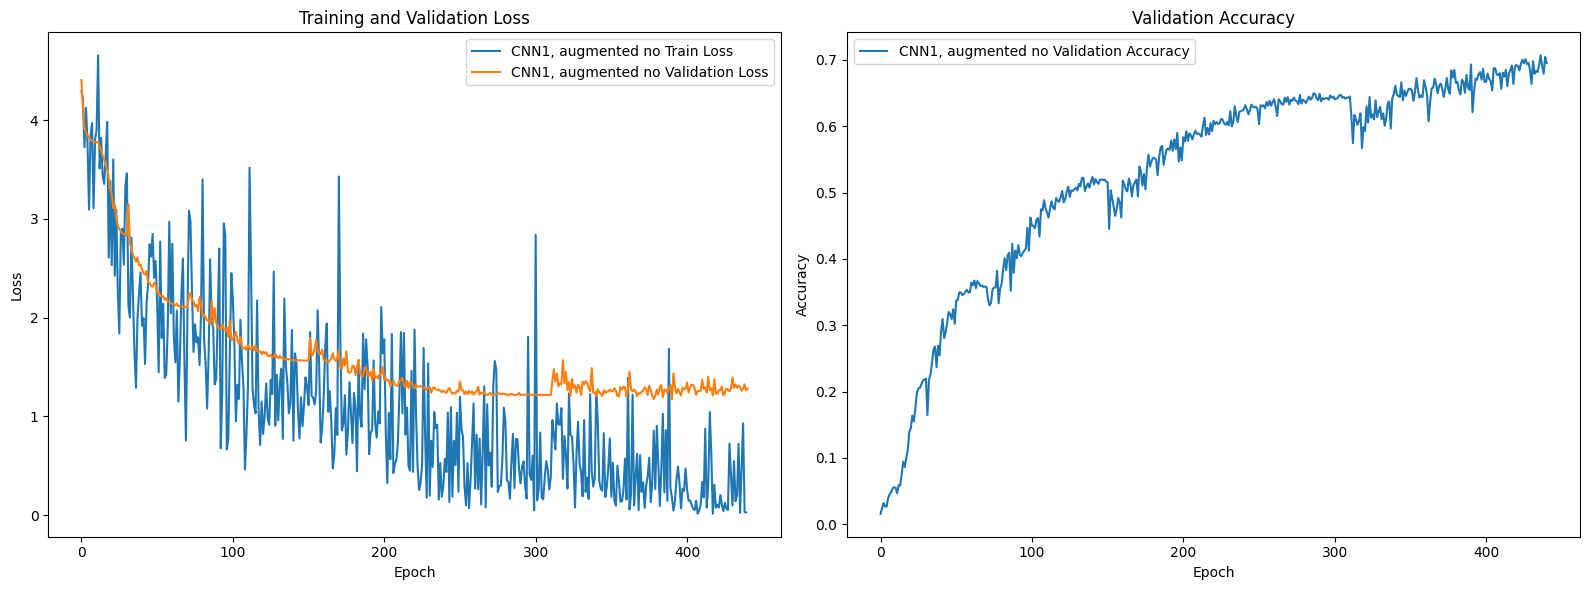

In [13]:
cnn1_df = results_df[results_df['Model'] == model.__class__.__name__]
print_val_accuracy_loss_epoch(cnn1_df)
plot_results(cnn1_df)

## CNN 2

In [14]:
class CNN2(BaseCNN):
    def __init__(self, num_classes, learning_rate):
        super().__init__(learning_rate, num_classes=num_classes)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # More initial filters
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 512)  # More neurons in FC layers
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate and train CNN2
model = CNN2(num_classes, learning_rate=learning_rate)
model, trainer, metrics_logger = train_model(model, train_loader, val_loader, max_epochs=max_epochs, early_stopping_patience=patience)
results_df = add_results(model, trainer, metrics_logger, train_loader, val_loader, test_loader, augmented='no')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\User\Documents\BZU\Vision\Final_Project\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name        | Type               | Params | Mode 
------------------------------------------------------------
0  | loss_fn     | CrossEntropyLoss   | 0      | train
1  | accuracy    | MulticlassAccuracy | 0      | train
2  | conv1       | Conv2d             | 320    | train
3  | bn1         | BatchNorm2d        | 64     | train
4  | conv2       | Conv2d             | 18.5 K | train
5  | bn2         | BatchNorm2d        | 128    | train
6  | pool        | MaxPool2d          | 0      | train
7  | conv3       | Conv2d             | 73

Epoch 0: 100%|██████████| 90/90 [00:06<00:00, 14.00it/s, v_num=23]         

Metric val_loss improved. New best score: 34.233
Epoch 0, global step 90: 'val_loss' reached 34.23318 (best 34.23318), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v14.ckpt' as top 1


Epoch 1: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 1, global step 180: 'val_loss' was not in top 1


Epoch 2: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 2, global step 270: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Metric val_loss improved by 31.172 >= min_delta = 0.001. New best score: 3.061
Epoch 3, global step 360: 'val_loss' reached 3.06107 (best 3.06107), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v14.ckpt' as top 1


Epoch 4: 100%|██████████| 90/90 [00:06<00:00, 14.50it/s, v_num=23]

Epoch 4, global step 450: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 5, global step 540: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 6, global step 630: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 90/90 [00:06<00:00, 14.63it/s, v_num=23]

Epoch 7, global step 720: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Metric val_loss improved by 0.367 >= min_delta = 0.001. New best score: 2.694
Epoch 8, global step 810: 'val_loss' reached 2.69413 (best 2.69413), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v14.ckpt' as top 1


Epoch 9: 100%|██████████| 90/90 [00:06<00:00, 14.54it/s, v_num=23]

Metric val_loss improved by 0.766 >= min_delta = 0.001. New best score: 1.928
Epoch 9, global step 900: 'val_loss' reached 1.92795 (best 1.92795), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v14.ckpt' as top 1


Epoch 10: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 10, global step 990: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 11, global step 1080: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 12, global step 1170: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 90/90 [00:06<00:00, 14.63it/s, v_num=23]

Epoch 13, global step 1260: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 90/90 [00:06<00:00, 14.53it/s, v_num=23]

Epoch 14, global step 1350: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 15, global step 1440: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 16, global step 1530: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 17, global step 1620: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 18, global step 1710: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 90/90 [00:06<00:00, 14.52it/s, v_num=23]

Epoch 19, global step 1800: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 20, global step 1890: 'val_loss' was not in top 1


Epoch 21: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 21, global step 1980: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 22, global step 2070: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 23, global step 2160: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 90/90 [00:06<00:00, 14.53it/s, v_num=23]

Epoch 24, global step 2250: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 25, global step 2340: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 26, global step 2430: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Metric val_loss improved by 0.850 >= min_delta = 0.001. New best score: 1.078
Epoch 27, global step 2520: 'val_loss' reached 1.07773 (best 1.07773), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v14.ckpt' as top 1


Epoch 28: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 28, global step 2610: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 90/90 [00:06<00:00, 14.51it/s, v_num=23]

Metric val_loss improved by 0.081 >= min_delta = 0.001. New best score: 0.997
Epoch 29, global step 2700: 'val_loss' reached 0.99718 (best 0.99718), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v14.ckpt' as top 1


Epoch 30: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 30, global step 2790: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 31, global step 2880: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 32, global step 2970: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 90/90 [00:06<00:00, 14.63it/s, v_num=23]

Epoch 33, global step 3060: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 90/90 [00:06<00:00, 14.52it/s, v_num=23]

Epoch 34, global step 3150: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 35, global step 3240: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 36, global step 3330: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 37, global step 3420: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 38, global step 3510: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 90/90 [00:06<00:00, 14.51it/s, v_num=23]

Epoch 39, global step 3600: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 90/90 [00:06<00:00, 14.63it/s, v_num=23]

Epoch 40, global step 3690: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 41, global step 3780: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 90/90 [00:06<00:00, 14.61it/s, v_num=23]

Epoch 42, global step 3870: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 43, global step 3960: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 90/90 [00:06<00:00, 14.52it/s, v_num=23]

Epoch 44, global step 4050: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 45, global step 4140: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 46, global step 4230: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 47, global step 4320: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 48, global step 4410: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 90/90 [00:06<00:00, 14.50it/s, v_num=23]

Epoch 49, global step 4500: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 50, global step 4590: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 51, global step 4680: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 52, global step 4770: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 53, global step 4860: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 90/90 [00:06<00:00, 14.52it/s, v_num=23]

Epoch 54, global step 4950: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 55, global step 5040: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 90/90 [00:06<00:00, 14.63it/s, v_num=23]

Epoch 56, global step 5130: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 57, global step 5220: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 58, global step 5310: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 90/90 [00:06<00:00, 14.53it/s, v_num=23]

Epoch 59, global step 5400: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 90/90 [00:06<00:00, 14.68it/s, v_num=23]

Epoch 60, global step 5490: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 61, global step 5580: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 62, global step 5670: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 63, global step 5760: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 90/90 [00:06<00:00, 14.51it/s, v_num=23]

Epoch 64, global step 5850: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 65, global step 5940: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 66, global step 6030: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 90/90 [00:06<00:00, 14.63it/s, v_num=23]

Metric val_loss improved by 0.336 >= min_delta = 0.001. New best score: 0.661
Epoch 67, global step 6120: 'val_loss' reached 0.66138 (best 0.66138), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v14.ckpt' as top 1


Epoch 68: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.657
Epoch 68, global step 6210: 'val_loss' reached 0.65724 (best 0.65724), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v14.ckpt' as top 1


Epoch 69: 100%|██████████| 90/90 [00:06<00:00, 14.53it/s, v_num=23]

Metric val_loss improved by 0.043 >= min_delta = 0.001. New best score: 0.614
Epoch 69, global step 6300: 'val_loss' reached 0.61385 (best 0.61385), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v14.ckpt' as top 1


Epoch 70: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 70, global step 6390: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 71, global step 6480: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 72, global step 6570: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 73, global step 6660: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 90/90 [00:06<00:00, 14.52it/s, v_num=23]

Epoch 74, global step 6750: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 75, global step 6840: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 76, global step 6930: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 77, global step 7020: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 78, global step 7110: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 90/90 [00:06<00:00, 14.52it/s, v_num=23]

Epoch 79, global step 7200: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 80, global step 7290: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 90/90 [00:06<00:00, 14.63it/s, v_num=23]

Epoch 81, global step 7380: 'val_loss' was not in top 1


Epoch 82: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 82, global step 7470: 'val_loss' was not in top 1


Epoch 83: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 83, global step 7560: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 90/90 [00:06<00:00, 14.52it/s, v_num=23]

Epoch 84, global step 7650: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 85, global step 7740: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 86, global step 7830: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 87, global step 7920: 'val_loss' was not in top 1


Epoch 88: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 88, global step 8010: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 90/90 [00:06<00:00, 14.53it/s, v_num=23]

Epoch 89, global step 8100: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 90/90 [00:06<00:00, 14.62it/s, v_num=23]

Epoch 90, global step 8190: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 91, global step 8280: 'val_loss' was not in top 1


Epoch 92: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 92, global step 8370: 'val_loss' was not in top 1


Epoch 93: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 93, global step 8460: 'val_loss' was not in top 1


Epoch 94: 100%|██████████| 90/90 [00:06<00:00, 14.51it/s, v_num=23]

Epoch 94, global step 8550: 'val_loss' was not in top 1


Epoch 95: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 95, global step 8640: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 96, global step 8730: 'val_loss' was not in top 1


Epoch 97: 100%|██████████| 90/90 [00:06<00:00, 14.62it/s, v_num=23]

Epoch 97, global step 8820: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 98, global step 8910: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 90/90 [00:06<00:00, 14.53it/s, v_num=23]

Epoch 99, global step 9000: 'val_loss' was not in top 1


Epoch 100: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 100, global step 9090: 'val_loss' was not in top 1


Epoch 101: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 101, global step 9180: 'val_loss' was not in top 1


Epoch 102: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 102, global step 9270: 'val_loss' was not in top 1


Epoch 103: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 103, global step 9360: 'val_loss' was not in top 1


Epoch 104: 100%|██████████| 90/90 [00:06<00:00, 14.53it/s, v_num=23]

Epoch 104, global step 9450: 'val_loss' was not in top 1


Epoch 105: 100%|██████████| 90/90 [00:06<00:00, 14.63it/s, v_num=23]

Epoch 105, global step 9540: 'val_loss' was not in top 1


Epoch 106: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 106, global step 9630: 'val_loss' was not in top 1


Epoch 107: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=23]

Epoch 107, global step 9720: 'val_loss' was not in top 1


Epoch 108: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 108, global step 9810: 'val_loss' was not in top 1


Epoch 109: 100%|██████████| 90/90 [00:06<00:00, 14.54it/s, v_num=23]

Epoch 109, global step 9900: 'val_loss' was not in top 1


Epoch 110: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 110, global step 9990: 'val_loss' was not in top 1


Epoch 111: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 111, global step 10080: 'val_loss' was not in top 1


Epoch 112: 100%|██████████| 90/90 [00:06<00:00, 14.62it/s, v_num=23]

Epoch 112, global step 10170: 'val_loss' was not in top 1


Epoch 113: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 113, global step 10260: 'val_loss' was not in top 1


Epoch 114: 100%|██████████| 90/90 [00:06<00:00, 14.51it/s, v_num=23]

Epoch 114, global step 10350: 'val_loss' was not in top 1


Epoch 115: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 115, global step 10440: 'val_loss' was not in top 1


Epoch 116: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=23]

Epoch 116, global step 10530: 'val_loss' was not in top 1


Epoch 117: 100%|██████████| 90/90 [00:06<00:00, 14.62it/s, v_num=23]

Epoch 117, global step 10620: 'val_loss' was not in top 1


Epoch 118: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=23]

Epoch 118, global step 10710: 'val_loss' was not in top 1


Epoch 119: 100%|██████████| 90/90 [00:06<00:00, 14.51it/s, v_num=23]

Monitored metric val_loss did not improve in the last 50 records. Best score: 0.614. Signaling Trainer to stop.
Epoch 119, global step 10800: 'val_loss' was not in top 1


Epoch 119: 100%|██████████| 90/90 [00:06<00:00, 14.51it/s, v_num=23]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing DataLoader 0: 100%|██████████| 90/90 [00:02<00:00, 33.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9229959845542908
        test_loss           0.3024422228336334
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 25.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7831423878669739
        test_loss           0.6138526797294617
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 25.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8091728091239929
        test_loss           0.6041532158851624
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Get CNN Results

Best Validation Accuracy: 0.7831 at epoch 71, Validation Loss: 0.6139


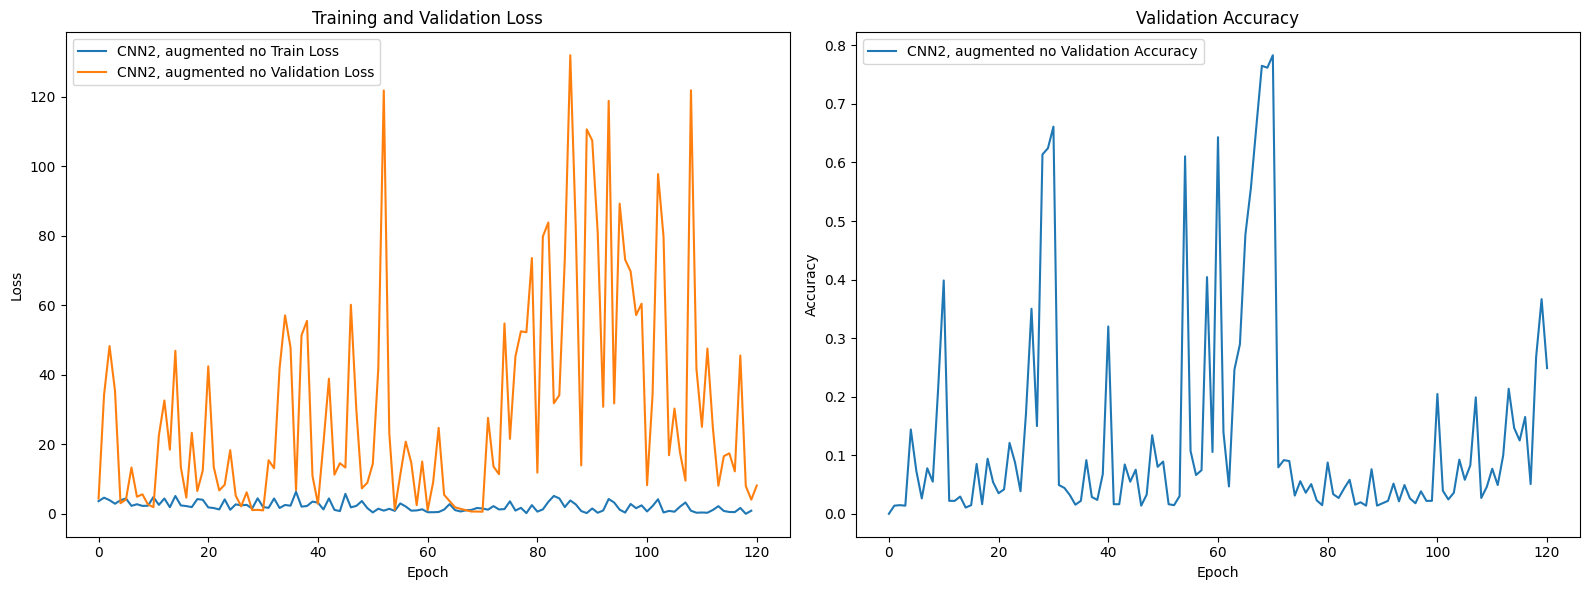

In [15]:
cnn2_df = results_df[results_df['Model'] == model.__class__.__name__]
print_val_accuracy_loss_epoch(cnn2_df)
plot_results(cnn2_df)


## CNN 3

In [16]:
class CNN3(BaseCNN):
    def __init__(self, num_classes, learning_rate):
        super().__init__(learning_rate, num_classes=num_classes)

        # Feature extractor
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  # Aggressively reduce size
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),  # Significantly fewer neurons
            nn.ReLU(),
            nn.Dropout(0.3),  # Reduced dropout for speed
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = torch.flatten(x, 1)  # Flatten for the classifier
        x = self.classifier(x)  # Classification
        return x

model = CNN3(num_classes, learning_rate=learning_rate)
model, trainer, metrics_logger = train_model(model, train_loader, val_loader, max_epochs=max_epochs, early_stopping_patience=patience)
results_df = add_results(model, trainer, metrics_logger, train_loader, val_loader, test_loader, augmented='no')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\User\Documents\BZU\Vision\Final_Project\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | loss_fn    | CrossEntropyLoss   | 0      | train
1 | accuracy   | MulticlassAccuracy | 0      | train
2 | features   | Sequential         | 387 K  | train
3 | classifier | Sequential         | 2.1 M  | train
----------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.110    Total estimated model params size (MB)
20        Modules in train mod

Epoch 0: 100%|██████████| 90/90 [00:05<00:00, 17.04it/s, v_num=24]         

Metric val_loss improved. New best score: 3.778
Epoch 0, global step 90: 'val_loss' reached 3.77848 (best 3.77848), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 1: 100%|██████████| 90/90 [00:05<00:00, 17.84it/s, v_num=24]

Metric val_loss improved by 0.427 >= min_delta = 0.001. New best score: 3.352
Epoch 1, global step 180: 'val_loss' reached 3.35172 (best 3.35172), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 2: 100%|██████████| 90/90 [00:04<00:00, 18.09it/s, v_num=24]

Metric val_loss improved by 0.288 >= min_delta = 0.001. New best score: 3.064
Epoch 2, global step 270: 'val_loss' reached 3.06410 (best 3.06410), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 3: 100%|██████████| 90/90 [00:04<00:00, 18.06it/s, v_num=24]

Metric val_loss improved by 0.157 >= min_delta = 0.001. New best score: 2.907
Epoch 3, global step 360: 'val_loss' reached 2.90744 (best 2.90744), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 4: 100%|██████████| 90/90 [00:05<00:00, 17.89it/s, v_num=24]

Metric val_loss improved by 0.159 >= min_delta = 0.001. New best score: 2.749
Epoch 4, global step 450: 'val_loss' reached 2.74871 (best 2.74871), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 5: 100%|██████████| 90/90 [00:04<00:00, 18.04it/s, v_num=24]

Metric val_loss improved by 0.203 >= min_delta = 0.001. New best score: 2.546
Epoch 5, global step 540: 'val_loss' reached 2.54553 (best 2.54553), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 6: 100%|██████████| 90/90 [00:05<00:00, 17.99it/s, v_num=24]

Metric val_loss improved by 0.133 >= min_delta = 0.001. New best score: 2.413
Epoch 6, global step 630: 'val_loss' reached 2.41298 (best 2.41298), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 7: 100%|██████████| 90/90 [00:04<00:00, 18.03it/s, v_num=24]

Metric val_loss improved by 0.163 >= min_delta = 0.001. New best score: 2.250
Epoch 7, global step 720: 'val_loss' reached 2.25042 (best 2.25042), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 8: 100%|██████████| 90/90 [00:04<00:00, 18.03it/s, v_num=24]

Metric val_loss improved by 0.042 >= min_delta = 0.001. New best score: 2.208
Epoch 8, global step 810: 'val_loss' reached 2.20833 (best 2.20833), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 9: 100%|██████████| 90/90 [00:05<00:00, 17.86it/s, v_num=24]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 2.198
Epoch 9, global step 900: 'val_loss' reached 2.19839 (best 2.19839), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 10: 100%|██████████| 90/90 [00:04<00:00, 18.01it/s, v_num=24]

Epoch 10, global step 990: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 90/90 [00:04<00:00, 18.01it/s, v_num=24]

Metric val_loss improved by 0.102 >= min_delta = 0.001. New best score: 2.096
Epoch 11, global step 1080: 'val_loss' reached 2.09603 (best 2.09603), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 12: 100%|██████████| 90/90 [00:04<00:00, 18.04it/s, v_num=24]

Metric val_loss improved by 0.158 >= min_delta = 0.001. New best score: 1.938
Epoch 12, global step 1170: 'val_loss' reached 1.93833 (best 1.93833), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 13: 100%|██████████| 90/90 [00:05<00:00, 17.99it/s, v_num=24]

Metric val_loss improved by 0.098 >= min_delta = 0.001. New best score: 1.841
Epoch 13, global step 1260: 'val_loss' reached 1.84071 (best 1.84071), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 14: 100%|██████████| 90/90 [00:05<00:00, 17.85it/s, v_num=24]

Epoch 14, global step 1350: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 90/90 [00:04<00:00, 18.04it/s, v_num=24]

Metric val_loss improved by 0.168 >= min_delta = 0.001. New best score: 1.673
Epoch 15, global step 1440: 'val_loss' reached 1.67253 (best 1.67253), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 16: 100%|██████████| 90/90 [00:04<00:00, 18.01it/s, v_num=24]

Metric val_loss improved by 0.084 >= min_delta = 0.001. New best score: 1.588
Epoch 16, global step 1530: 'val_loss' reached 1.58824 (best 1.58824), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 17: 100%|██████████| 90/90 [00:04<00:00, 18.01it/s, v_num=24]

Epoch 17, global step 1620: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 90/90 [00:04<00:00, 18.04it/s, v_num=24]

Metric val_loss improved by 0.071 >= min_delta = 0.001. New best score: 1.517
Epoch 18, global step 1710: 'val_loss' reached 1.51744 (best 1.51744), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 19: 100%|██████████| 90/90 [00:05<00:00, 17.86it/s, v_num=24]

Epoch 19, global step 1800: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 90/90 [00:04<00:00, 18.02it/s, v_num=24]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 1.512
Epoch 20, global step 1890: 'val_loss' reached 1.51208 (best 1.51208), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v15.ckpt' as top 1


Epoch 21: 100%|██████████| 90/90 [00:04<00:00, 18.01it/s, v_num=24]

Epoch 21, global step 1980: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 90/90 [00:04<00:00, 18.01it/s, v_num=24]

Epoch 22, global step 2070: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 90/90 [00:04<00:00, 18.02it/s, v_num=24]

Epoch 23, global step 2160: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 90/90 [00:05<00:00, 17.86it/s, v_num=24]

Epoch 24, global step 2250: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 90/90 [00:04<00:00, 18.02it/s, v_num=24]

Epoch 25, global step 2340: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 90/90 [00:04<00:00, 18.01it/s, v_num=24]

Epoch 26, global step 2430: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 90/90 [00:04<00:00, 18.02it/s, v_num=24]

Epoch 27, global step 2520: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 90/90 [00:04<00:00, 18.00it/s, v_num=24]

Epoch 28, global step 2610: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 90/90 [00:05<00:00, 17.88it/s, v_num=24]

Epoch 29, global step 2700: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 90/90 [00:04<00:00, 18.02it/s, v_num=24]

Epoch 30, global step 2790: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 90/90 [00:04<00:00, 18.00it/s, v_num=24]

Epoch 31, global step 2880: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 90/90 [00:05<00:00, 17.99it/s, v_num=24]

Epoch 32, global step 2970: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 90/90 [00:04<00:00, 18.02it/s, v_num=24]

Epoch 33, global step 3060: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 90/90 [00:05<00:00, 17.83it/s, v_num=24]

Epoch 34, global step 3150: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 90/90 [00:04<00:00, 18.04it/s, v_num=24]

Epoch 35, global step 3240: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 90/90 [00:05<00:00, 18.00it/s, v_num=24]

Epoch 36, global step 3330: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 90/90 [00:04<00:00, 18.02it/s, v_num=24]

Epoch 37, global step 3420: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 90/90 [00:04<00:00, 18.01it/s, v_num=24]

Epoch 38, global step 3510: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 90/90 [00:05<00:00, 17.86it/s, v_num=24]

Epoch 39, global step 3600: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 90/90 [00:04<00:00, 18.03it/s, v_num=24]

Epoch 40, global step 3690: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 90/90 [00:05<00:00, 17.99it/s, v_num=24]

Epoch 41, global step 3780: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 90/90 [00:04<00:00, 18.02it/s, v_num=24]

Epoch 42, global step 3870: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 90/90 [00:04<00:00, 18.03it/s, v_num=24]

Epoch 43, global step 3960: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 90/90 [00:05<00:00, 17.89it/s, v_num=24]

Epoch 44, global step 4050: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 90/90 [00:04<00:00, 18.00it/s, v_num=24]

Epoch 45, global step 4140: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 90/90 [00:04<00:00, 18.02it/s, v_num=24]

Epoch 46, global step 4230: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 90/90 [00:05<00:00, 18.00it/s, v_num=24]

Epoch 47, global step 4320: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 90/90 [00:05<00:00, 17.98it/s, v_num=24]

Epoch 48, global step 4410: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 90/90 [00:05<00:00, 17.87it/s, v_num=24]

Epoch 49, global step 4500: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 90/90 [00:04<00:00, 18.01it/s, v_num=24]

Epoch 50, global step 4590: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 90/90 [00:04<00:00, 18.01it/s, v_num=24]

Epoch 51, global step 4680: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 90/90 [00:04<00:00, 18.03it/s, v_num=24]

Epoch 52, global step 4770: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 90/90 [00:04<00:00, 18.01it/s, v_num=24]

Epoch 53, global step 4860: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 90/90 [00:05<00:00, 17.87it/s, v_num=24]

Epoch 54, global step 4950: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 90/90 [00:04<00:00, 18.03it/s, v_num=24]

Epoch 55, global step 5040: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 90/90 [00:05<00:00, 17.99it/s, v_num=24]

Epoch 56, global step 5130: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 90/90 [00:04<00:00, 18.01it/s, v_num=24]

Epoch 57, global step 5220: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 90/90 [00:04<00:00, 18.02it/s, v_num=24]

Epoch 58, global step 5310: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 90/90 [00:05<00:00, 17.86it/s, v_num=24]

Epoch 59, global step 5400: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 90/90 [00:04<00:00, 18.03it/s, v_num=24]

Epoch 60, global step 5490: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 90/90 [00:04<00:00, 18.01it/s, v_num=24]

Epoch 61, global step 5580: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 90/90 [00:04<00:00, 18.01it/s, v_num=24]

Epoch 62, global step 5670: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 90/90 [00:05<00:00, 17.99it/s, v_num=24]

Epoch 63, global step 5760: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 90/90 [00:05<00:00, 17.85it/s, v_num=24]

Epoch 64, global step 5850: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 90/90 [00:04<00:00, 18.02it/s, v_num=24]

Epoch 65, global step 5940: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 90/90 [00:05<00:00, 17.99it/s, v_num=24]

Epoch 66, global step 6030: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 90/90 [00:05<00:00, 17.99it/s, v_num=24]

Epoch 67, global step 6120: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 90/90 [00:05<00:00, 17.95it/s, v_num=24]

Epoch 68, global step 6210: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 90/90 [00:05<00:00, 17.85it/s, v_num=24]

Epoch 69, global step 6300: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 90/90 [00:04<00:00, 18.01it/s, v_num=24]

Monitored metric val_loss did not improve in the last 50 records. Best score: 1.512. Signaling Trainer to stop.
Epoch 70, global step 6390: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 90/90 [00:05<00:00, 18.00it/s, v_num=24]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing DataLoader 0: 100%|██████████| 90/90 [00:02<00:00, 39.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9475530385971069
        test_loss           0.22956541180610657
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 30.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6227495670318604
        test_loss            1.512080192565918
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 24.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6117936372756958
        test_loss            1.628760576248169
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Get CNN Results

Best Validation Accuracy: 0.6227 at epoch 22, Validation Loss: 1.5121


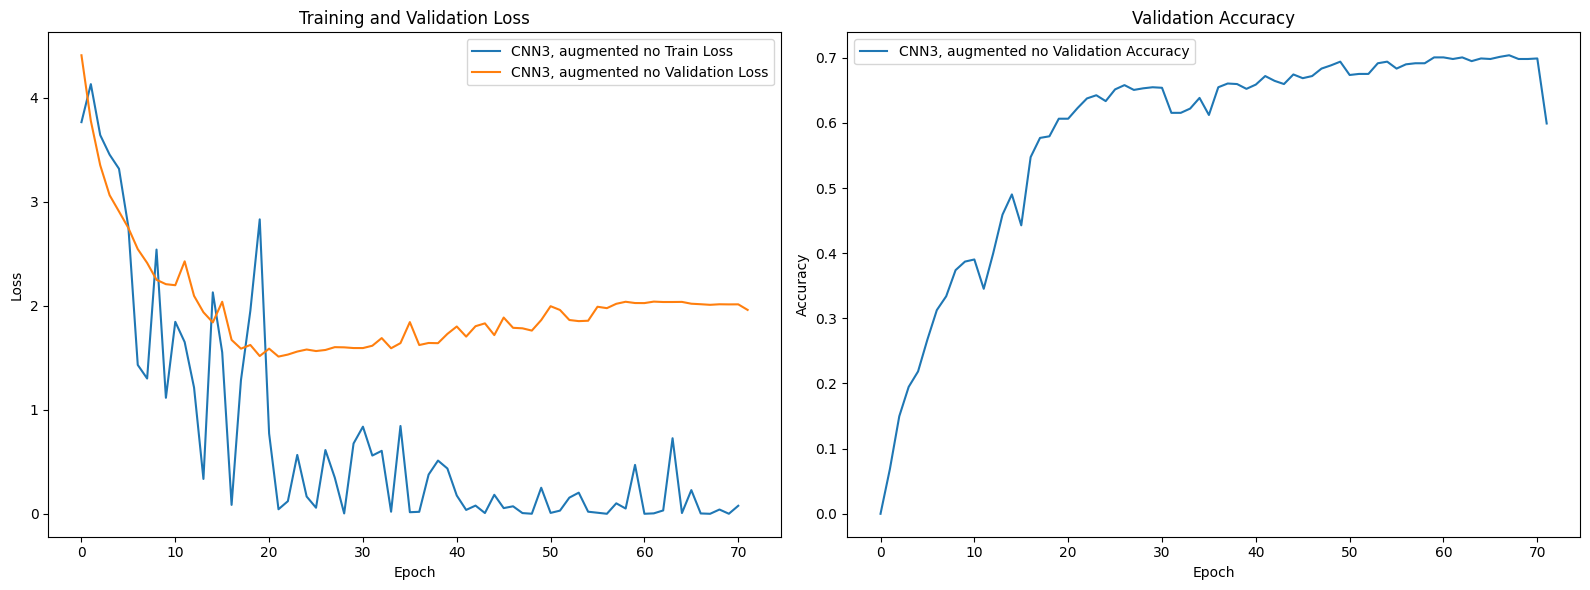

In [17]:
cnn3_df = results_df[results_df['Model'] == model.__class__.__name__]
print_val_accuracy_loss_epoch(cnn3_df)
plot_results(cnn3_df)

# Task 2: Retrain Selected CNN After Doing Data Augmentation.

In [18]:
augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.2)),
    transforms.RandomRotation(degrees=(-15, 15)),  # Reduced rotation
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Reduced translation
    transforms.RandomPerspective(distortion_scale=0.05, p=0.2),  # Reduced distortion
    transforms.RandomErasing(p=0.1),  # Reduced probability of erasing or removed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalization stays
])

train_dataset.transform = augment_transform


### Show some samples of augmented images

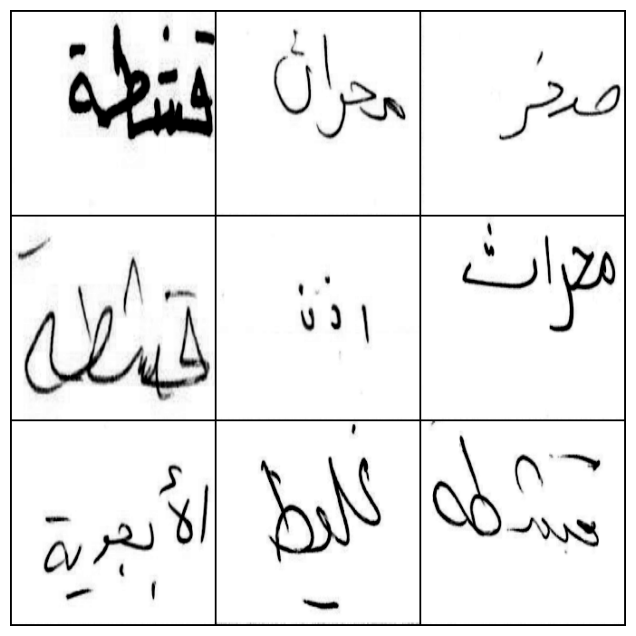

In [19]:

show_images_in_grid(train_loader)

### Train The Best Model With Augmented Images

In [20]:
model = CNN2(num_classes, learning_rate=learning_rate)
model, trainer, metrics_logger = train_model(model, train_loader, val_loader, max_epochs=max_epochs, early_stopping_patience=patience)
results_df = add_results(model, trainer, metrics_logger, train_loader, val_loader, test_loader, augmented='yes')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\User\Documents\BZU\Vision\Final_Project\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name        | Type               | Params | Mode 
------------------------------------------------------------
0  | loss_fn     | CrossEntropyLoss   | 0      | train
1  | accuracy    | MulticlassAccuracy | 0      | train
2  | conv1       | Conv2d             | 320    | train
3  | bn1         | BatchNorm2d        | 64     | train
4  | conv2       | Conv2d             | 18.5 K | train
5  | bn2         | BatchNorm2d        | 128    | train
6  | pool        | MaxPool2d          | 0      | train
7  | conv3       | Conv2d             | 73

Epoch 0: 100%|██████████| 90/90 [00:06<00:00, 14.56it/s, v_num=25]         

Metric val_loss improved. New best score: 30.817
Epoch 0, global step 90: 'val_loss' reached 30.81723 (best 30.81723), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v16.ckpt' as top 1


Epoch 1: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 1, global step 180: 'val_loss' was not in top 1


Epoch 2: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Metric val_loss improved by 20.550 >= min_delta = 0.001. New best score: 10.267
Epoch 2, global step 270: 'val_loss' reached 10.26699 (best 10.26699), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v16.ckpt' as top 1


Epoch 3: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 3, global step 360: 'val_loss' was not in top 1


Epoch 4: 100%|██████████| 90/90 [00:06<00:00, 14.52it/s, v_num=25]

Epoch 4, global step 450: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Metric val_loss improved by 2.252 >= min_delta = 0.001. New best score: 8.015
Epoch 5, global step 540: 'val_loss' reached 8.01524 (best 8.01524), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v16.ckpt' as top 1


Epoch 6: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 6, global step 630: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Metric val_loss improved by 2.711 >= min_delta = 0.001. New best score: 5.304
Epoch 7, global step 720: 'val_loss' reached 5.30429 (best 5.30429), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v16.ckpt' as top 1


Epoch 8: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Metric val_loss improved by 2.318 >= min_delta = 0.001. New best score: 2.987
Epoch 8, global step 810: 'val_loss' reached 2.98653 (best 2.98653), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v16.ckpt' as top 1


Epoch 9: 100%|██████████| 90/90 [00:06<00:00, 14.52it/s, v_num=25]

Metric val_loss improved by 0.337 >= min_delta = 0.001. New best score: 2.650
Epoch 9, global step 900: 'val_loss' reached 2.64956 (best 2.64956), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v16.ckpt' as top 1


Epoch 10: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 10, global step 990: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 11, global step 1080: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=25]

Epoch 12, global step 1170: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 13, global step 1260: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 90/90 [00:06<00:00, 14.54it/s, v_num=25]

Epoch 14, global step 1350: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 15, global step 1440: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 90/90 [00:06<00:00, 14.63it/s, v_num=25]

Epoch 16, global step 1530: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 90/90 [00:06<00:00, 14.63it/s, v_num=25]

Epoch 17, global step 1620: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 18, global step 1710: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 90/90 [00:06<00:00, 14.52it/s, v_num=25]

Epoch 19, global step 1800: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 20, global step 1890: 'val_loss' was not in top 1


Epoch 21: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=25]

Epoch 21, global step 1980: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 90/90 [00:06<00:00, 14.62it/s, v_num=25]

Metric val_loss improved by 0.888 >= min_delta = 0.001. New best score: 1.762
Epoch 22, global step 2070: 'val_loss' reached 1.76158 (best 1.76158), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v16.ckpt' as top 1


Epoch 23: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=25]

Epoch 23, global step 2160: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 90/90 [00:06<00:00, 14.53it/s, v_num=25]

Epoch 24, global step 2250: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Metric val_loss improved by 0.324 >= min_delta = 0.001. New best score: 1.437
Epoch 25, global step 2340: 'val_loss' reached 1.43724 (best 1.43724), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v16.ckpt' as top 1


Epoch 26: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 26, global step 2430: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Metric val_loss improved by 0.147 >= min_delta = 0.001. New best score: 1.290
Epoch 27, global step 2520: 'val_loss' reached 1.28990 (best 1.28990), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v16.ckpt' as top 1


Epoch 28: 100%|██████████| 90/90 [00:06<00:00, 14.63it/s, v_num=25]

Metric val_loss improved by 0.308 >= min_delta = 0.001. New best score: 0.982
Epoch 28, global step 2610: 'val_loss' reached 0.98233 (best 0.98233), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v16.ckpt' as top 1


Epoch 29: 100%|██████████| 90/90 [00:06<00:00, 14.53it/s, v_num=25]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.974
Epoch 29, global step 2700: 'val_loss' reached 0.97443 (best 0.97443), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v16.ckpt' as top 1


Epoch 30: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=25]

Epoch 30, global step 2790: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 90/90 [00:06<00:00, 14.63it/s, v_num=25]

Epoch 31, global step 2880: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 32, global step 2970: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 33, global step 3060: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 90/90 [00:06<00:00, 14.52it/s, v_num=25]

Epoch 34, global step 3150: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 35, global step 3240: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 36, global step 3330: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=25]

Epoch 37, global step 3420: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=25]

Epoch 38, global step 3510: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 90/90 [00:06<00:00, 14.53it/s, v_num=25]

Epoch 39, global step 3600: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 40, global step 3690: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 41, global step 3780: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 42, global step 3870: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 43, global step 3960: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 90/90 [00:06<00:00, 14.53it/s, v_num=25]

Epoch 44, global step 4050: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 45, global step 4140: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 46, global step 4230: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 47, global step 4320: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 48, global step 4410: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 90/90 [00:06<00:00, 14.54it/s, v_num=25]

Epoch 49, global step 4500: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 90/90 [00:06<00:00, 14.67it/s, v_num=25]

Epoch 50, global step 4590: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 51, global step 4680: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 90/90 [00:06<00:00, 14.67it/s, v_num=25]

Epoch 52, global step 4770: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=25]

Epoch 53, global step 4860: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 90/90 [00:06<00:00, 14.55it/s, v_num=25]

Epoch 54, global step 4950: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 55, global step 5040: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 56, global step 5130: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=25]

Epoch 57, global step 5220: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 58, global step 5310: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 90/90 [00:06<00:00, 14.54it/s, v_num=25]

Epoch 59, global step 5400: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 60, global step 5490: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 61, global step 5580: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 62, global step 5670: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Metric val_loss improved by 0.315 >= min_delta = 0.001. New best score: 0.659
Epoch 63, global step 5760: 'val_loss' reached 0.65928 (best 0.65928), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v16.ckpt' as top 1


Epoch 64: 100%|██████████| 90/90 [00:06<00:00, 14.52it/s, v_num=25]

Epoch 64, global step 5850: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 65, global step 5940: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 0.629
Epoch 66, global step 6030: 'val_loss' reached 0.62865 (best 0.62865), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v16.ckpt' as top 1


Epoch 67: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 67, global step 6120: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 68, global step 6210: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 90/90 [00:06<00:00, 14.50it/s, v_num=25]

Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 0.599
Epoch 69, global step 6300: 'val_loss' reached 0.59935 (best 0.59935), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v16.ckpt' as top 1


Epoch 70: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 70, global step 6390: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 71, global step 6480: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 72, global step 6570: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 73, global step 6660: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 90/90 [00:06<00:00, 14.53it/s, v_num=25]

Epoch 74, global step 6750: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 75, global step 6840: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 76, global step 6930: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 77, global step 7020: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 90/90 [00:06<00:00, 14.67it/s, v_num=25]

Epoch 78, global step 7110: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 90/90 [00:06<00:00, 14.53it/s, v_num=25]

Epoch 79, global step 7200: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=25]

Epoch 80, global step 7290: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 81, global step 7380: 'val_loss' was not in top 1


Epoch 82: 100%|██████████| 90/90 [00:06<00:00, 14.63it/s, v_num=25]

Epoch 82, global step 7470: 'val_loss' was not in top 1


Epoch 83: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 83, global step 7560: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 90/90 [00:06<00:00, 14.54it/s, v_num=25]

Epoch 84, global step 7650: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=25]

Epoch 85, global step 7740: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=25]

Epoch 86, global step 7830: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 87, global step 7920: 'val_loss' was not in top 1


Epoch 88: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 88, global step 8010: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 90/90 [00:06<00:00, 14.54it/s, v_num=25]

Epoch 89, global step 8100: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 90, global step 8190: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 91, global step 8280: 'val_loss' was not in top 1


Epoch 92: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 92, global step 8370: 'val_loss' was not in top 1


Epoch 93: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 93, global step 8460: 'val_loss' was not in top 1


Epoch 94: 100%|██████████| 90/90 [00:06<00:00, 14.55it/s, v_num=25]

Epoch 94, global step 8550: 'val_loss' was not in top 1


Epoch 95: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 95, global step 8640: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 96, global step 8730: 'val_loss' was not in top 1


Epoch 97: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 97, global step 8820: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 98, global step 8910: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 90/90 [00:06<00:00, 14.55it/s, v_num=25]

Epoch 99, global step 9000: 'val_loss' was not in top 1


Epoch 100: 100%|██████████| 90/90 [00:06<00:00, 14.67it/s, v_num=25]

Epoch 100, global step 9090: 'val_loss' was not in top 1


Epoch 101: 100%|██████████| 90/90 [00:06<00:00, 14.67it/s, v_num=25]

Epoch 101, global step 9180: 'val_loss' was not in top 1


Epoch 102: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 102, global step 9270: 'val_loss' was not in top 1


Epoch 103: 100%|██████████| 90/90 [00:06<00:00, 14.61it/s, v_num=25]

Epoch 103, global step 9360: 'val_loss' was not in top 1


Epoch 104: 100%|██████████| 90/90 [00:06<00:00, 14.53it/s, v_num=25]

Epoch 104, global step 9450: 'val_loss' was not in top 1


Epoch 105: 100%|██████████| 90/90 [00:06<00:00, 14.67it/s, v_num=25]

Epoch 105, global step 9540: 'val_loss' was not in top 1


Epoch 106: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 106, global step 9630: 'val_loss' was not in top 1


Epoch 107: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 107, global step 9720: 'val_loss' was not in top 1


Epoch 108: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 108, global step 9810: 'val_loss' was not in top 1


Epoch 109: 100%|██████████| 90/90 [00:06<00:00, 14.52it/s, v_num=25]

Epoch 109, global step 9900: 'val_loss' was not in top 1


Epoch 110: 100%|██████████| 90/90 [00:06<00:00, 14.67it/s, v_num=25]

Epoch 110, global step 9990: 'val_loss' was not in top 1


Epoch 111: 100%|██████████| 90/90 [00:06<00:00, 14.64it/s, v_num=25]

Epoch 111, global step 10080: 'val_loss' was not in top 1


Epoch 112: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 112, global step 10170: 'val_loss' was not in top 1


Epoch 113: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 113, global step 10260: 'val_loss' was not in top 1


Epoch 114: 100%|██████████| 90/90 [00:06<00:00, 14.51it/s, v_num=25]

Epoch 114, global step 10350: 'val_loss' was not in top 1


Epoch 115: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 115, global step 10440: 'val_loss' was not in top 1


Epoch 116: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 116, global step 10530: 'val_loss' was not in top 1


Epoch 117: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, v_num=25]

Epoch 117, global step 10620: 'val_loss' was not in top 1


Epoch 118: 100%|██████████| 90/90 [00:06<00:00, 14.66it/s, v_num=25]

Epoch 118, global step 10710: 'val_loss' was not in top 1


Epoch 119: 100%|██████████| 90/90 [00:06<00:00, 14.51it/s, v_num=25]

Monitored metric val_loss did not improve in the last 50 records. Best score: 0.599. Signaling Trainer to stop.
Epoch 119, global step 10800: 'val_loss' was not in top 1


Epoch 119: 100%|██████████| 90/90 [00:06<00:00, 14.51it/s, v_num=25]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing DataLoader 0: 100%|██████████| 90/90 [00:02<00:00, 35.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.927731990814209
        test_loss           0.2807202637195587
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 26.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7831423878669739
        test_loss           0.5993455052375793
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 24.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7936117649078369
        test_loss           0.6110249757766724
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Get CNN Results

Best Validation Accuracy: 0.7831 at epoch 71, Validation Loss: 0.5993


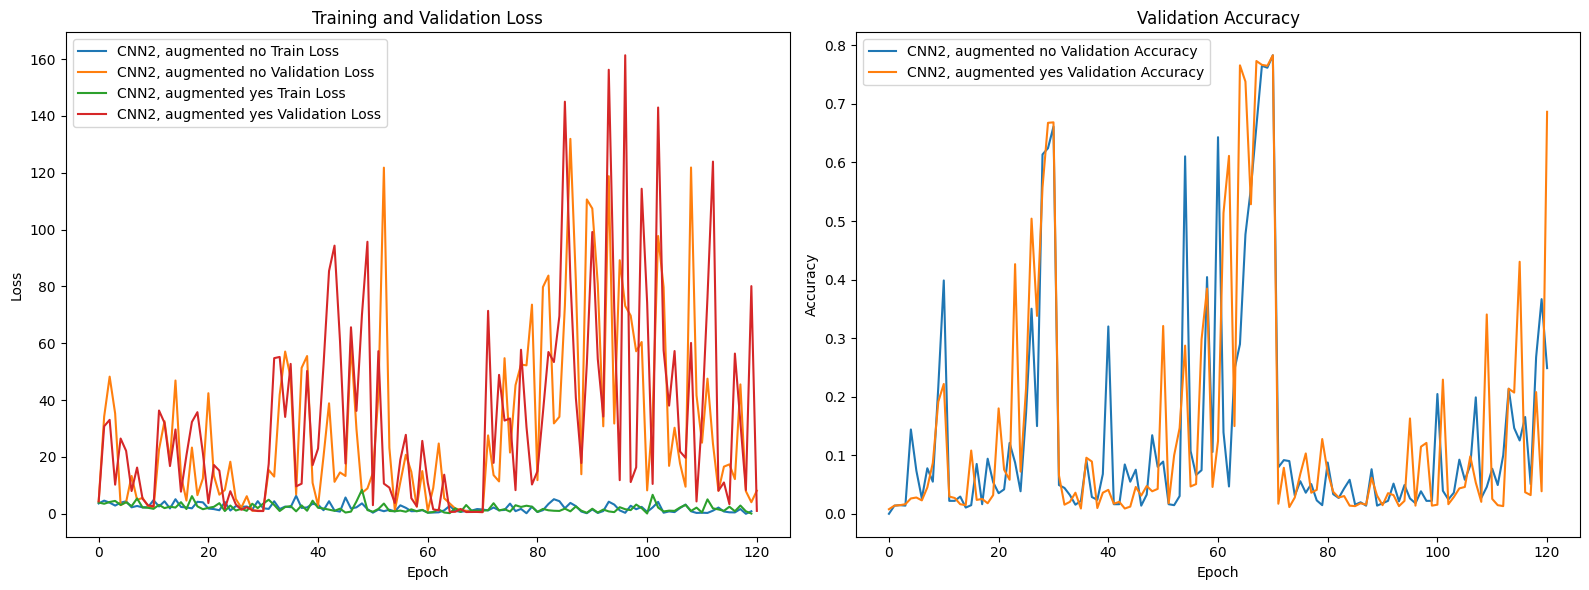

In [21]:
cnn_aug_df1 = results_df[results_df['Model'] == model.__class__.__name__]
print_val_accuracy_loss_epoch(cnn_aug_df1)
plot_results(cnn_aug_df1)

# Task 3: Train Published CNN With Data Augmentation

### Convert Images to RGB

In [22]:
augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.2)),
    transforms.RandomRotation(degrees=(-15, 15)),  # Reduced rotation
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Reduced translation
    transforms.RandomPerspective(distortion_scale=0.05, p=0.2),  # Reduced distortion
    transforms.RandomErasing(p=0.1),  # Reduced probability of erasing or removed
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])


base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])


val_dataset.dataset.transform = base
test_dataset.dataset.transform = base
train_dataset.transform = augment_transform

In [23]:
torch.cuda.empty_cache()

### Training

In [24]:
from torchvision.models import resnet18
class ResNet18SE(BaseCNN):
    def __init__(self, num_classes, learning_rate):
        super().__init__(learning_rate, num_classes=num_classes)
        
        # Initialize ResNet18 without pre-trained weights (trained from scratch)
        self.model = resnet18(pretrained=False)
        
        # Apply SE block modification to ResNet18
        self.model = self._add_se_block(self.model)
        
        # Replace the final classifier layer for the number of classes in your task
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)
        
    def _add_se_block(self, model):
        """Add SE Block to the model"""
        from torch import nn
        from torch.nn import functional as F

        class SELayer(nn.Module):
            def __init__(self, channel, reduction=16):
                super(SELayer, self).__init__()
                self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
                self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
                self.sigmoid = nn.Sigmoid()

            def forward(self, x):
                b, c, _, _ = x.size()
                y = F.adaptive_avg_pool2d(x, (1, 1))
                y = y.view(b, c)
                y = self.fc2(F.relu(self.fc1(y)))
                y = self.sigmoid(y).view(b, c, 1, 1)
                return x * y

        # Apply SE block to all ResNet blocks
        for name, module in model.named_children():
            if isinstance(module, nn.Sequential):
                for sub_name, sub_module in module.named_children():
                    if isinstance(sub_module, nn.Conv2d):
                        module.add_module(f'se_{sub_name}', SELayer(sub_module.out_channels))
        
        return model

    def forward(self, x):
        x = self.model(x)  # Forward pass through ResNet-18 with SE layers
        return x

# Initialize and train model
model = ResNet18SE(num_classes=num_classes, learning_rate=learning_rate)
model, trainer, metrics_logger = train_model(model, train_loader, val_loader, max_epochs=max_epochs, early_stopping_patience=patience)
results_df = add_results(model, trainer, metrics_logger, train_loader, val_loader, test_loader, augmented='yes')

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\callbacks\model_checkpo

Epoch 0: 100%|██████████| 90/90 [00:09<00:00,  9.48it/s, v_num=26]         

Metric val_loss improved. New best score: 44.515
Epoch 0, global step 90: 'val_loss' reached 44.51520 (best 44.51520), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v17.ckpt' as top 1


Epoch 1: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Metric val_loss improved by 42.003 >= min_delta = 0.001. New best score: 2.512
Epoch 1, global step 180: 'val_loss' reached 2.51193 (best 2.51193), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v17.ckpt' as top 1


Epoch 2: 100%|██████████| 90/90 [00:09<00:00,  9.83it/s, v_num=26]

Epoch 2, global step 270: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 3, global step 360: 'val_loss' was not in top 1


Epoch 4: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 4, global step 450: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 90/90 [00:09<00:00,  9.84it/s, v_num=26]

Epoch 5, global step 540: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 6, global step 630: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 7, global step 720: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Metric val_loss improved by 1.626 >= min_delta = 0.001. New best score: 0.886
Epoch 8, global step 810: 'val_loss' reached 0.88634 (best 0.88634), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v17.ckpt' as top 1


Epoch 9: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Metric val_loss improved by 0.112 >= min_delta = 0.001. New best score: 0.774
Epoch 9, global step 900: 'val_loss' reached 0.77399 (best 0.77399), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v17.ckpt' as top 1


Epoch 10: 100%|██████████| 90/90 [00:09<00:00,  9.86it/s, v_num=26]

Epoch 10, global step 990: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 11, global step 1080: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 12, global step 1170: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 13, global step 1260: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 14, global step 1350: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 15, global step 1440: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Epoch 16, global step 1530: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Epoch 17, global step 1620: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 18, global step 1710: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 19, global step 1800: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 20, global step 1890: 'val_loss' was not in top 1


Epoch 21: 100%|██████████| 90/90 [00:09<00:00,  9.86it/s, v_num=26]

Metric val_loss improved by 0.056 >= min_delta = 0.001. New best score: 0.718
Epoch 21, global step 1980: 'val_loss' reached 0.71795 (best 0.71795), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v17.ckpt' as top 1


Epoch 22: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 22, global step 2070: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Metric val_loss improved by 0.118 >= min_delta = 0.001. New best score: 0.600
Epoch 23, global step 2160: 'val_loss' reached 0.59978 (best 0.59978), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v17.ckpt' as top 1


Epoch 24: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 24, global step 2250: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Epoch 25, global step 2340: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 90/90 [00:09<00:00,  9.86it/s, v_num=26]

Metric val_loss improved by 0.117 >= min_delta = 0.001. New best score: 0.483
Epoch 26, global step 2430: 'val_loss' reached 0.48263 (best 0.48263), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v17.ckpt' as top 1


Epoch 27: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.470
Epoch 27, global step 2520: 'val_loss' reached 0.47021 (best 0.47021), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v17.ckpt' as top 1


Epoch 28: 100%|██████████| 90/90 [00:09<00:00,  9.84it/s, v_num=26]

Epoch 28, global step 2610: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.459
Epoch 29, global step 2700: 'val_loss' reached 0.45924 (best 0.45924), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v17.ckpt' as top 1


Epoch 30: 100%|██████████| 90/90 [00:09<00:00,  9.86it/s, v_num=26]

Epoch 30, global step 2790: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=26]

Epoch 31, global step 2880: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Epoch 32, global step 2970: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Epoch 33, global step 3060: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 90/90 [00:09<00:00,  9.86it/s, v_num=26]

Epoch 34, global step 3150: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 90/90 [00:09<00:00,  9.84it/s, v_num=26]

Epoch 35, global step 3240: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Epoch 36, global step 3330: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 90/90 [00:09<00:00,  9.83it/s, v_num=26]

Epoch 37, global step 3420: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 90/90 [00:09<00:00,  9.86it/s, v_num=26]

Epoch 38, global step 3510: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 90/90 [00:09<00:00,  9.86it/s, v_num=26]

Epoch 39, global step 3600: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 40, global step 3690: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 41, global step 3780: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 90/90 [00:09<00:00,  9.84it/s, v_num=26]

Epoch 42, global step 3870: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 90/90 [00:09<00:00,  9.84it/s, v_num=26]

Epoch 43, global step 3960: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 44, global step 4050: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Epoch 45, global step 4140: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Epoch 46, global step 4230: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Epoch 47, global step 4320: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 90/90 [00:09<00:00,  9.86it/s, v_num=26]

Epoch 48, global step 4410: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=26]

Epoch 49, global step 4500: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 90/90 [00:09<00:00,  9.86it/s, v_num=26]

Epoch 50, global step 4590: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 90/90 [00:09<00:00,  9.86it/s, v_num=26]

Epoch 51, global step 4680: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 90/90 [00:09<00:00,  9.86it/s, v_num=26]

Epoch 52, global step 4770: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 90/90 [00:09<00:00,  9.84it/s, v_num=26]

Epoch 53, global step 4860: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Epoch 54, global step 4950: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Epoch 55, global step 5040: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 90/90 [00:09<00:00,  9.92it/s, v_num=26]

Epoch 56, global step 5130: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 90/90 [00:09<00:00,  9.92it/s, v_num=26]

Epoch 57, global step 5220: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 90/90 [00:09<00:00,  9.92it/s, v_num=26]

Epoch 58, global step 5310: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=26]

Epoch 59, global step 5400: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 90/90 [00:09<00:00,  9.90it/s, v_num=26]

Epoch 60, global step 5490: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 90/90 [00:09<00:00,  9.90it/s, v_num=26]

Epoch 61, global step 5580: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 90/90 [00:09<00:00,  9.92it/s, v_num=26]

Epoch 62, global step 5670: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 90/90 [00:09<00:00,  9.92it/s, v_num=26]

Epoch 63, global step 5760: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 90/90 [00:09<00:00,  9.90it/s, v_num=26]

Epoch 64, global step 5850: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 90/90 [00:09<00:00,  9.91it/s, v_num=26]

Epoch 65, global step 5940: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=26]

Epoch 66, global step 6030: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=26]

Epoch 67, global step 6120: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=26]

Epoch 68, global step 6210: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=26]

Epoch 69, global step 6300: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Epoch 70, global step 6390: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=26]

Epoch 71, global step 6480: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Epoch 72, global step 6570: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=26]

Epoch 73, global step 6660: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=26]

Epoch 74, global step 6750: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=26]

Epoch 75, global step 6840: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=26]

Epoch 76, global step 6930: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=26]

Epoch 77, global step 7020: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=26]

Epoch 78, global step 7110: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=26]

Monitored metric val_loss did not improve in the last 50 records. Best score: 0.459. Signaling Trainer to stop.
Epoch 79, global step 7200: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=26]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing DataLoader 0: 100%|██████████| 90/90 [00:04<00:00, 21.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    1.0
        test_loss           0.00891868770122528
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:01<00:00, 18.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8625204563140869
        test_loss           0.4592427909374237
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:01<00:00, 18.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8550368547439575
        test_loss           0.4899667799472809
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Get CNN Results

Best Validation Accuracy: 0.8625 at epoch 31, Validation Loss: 0.4592


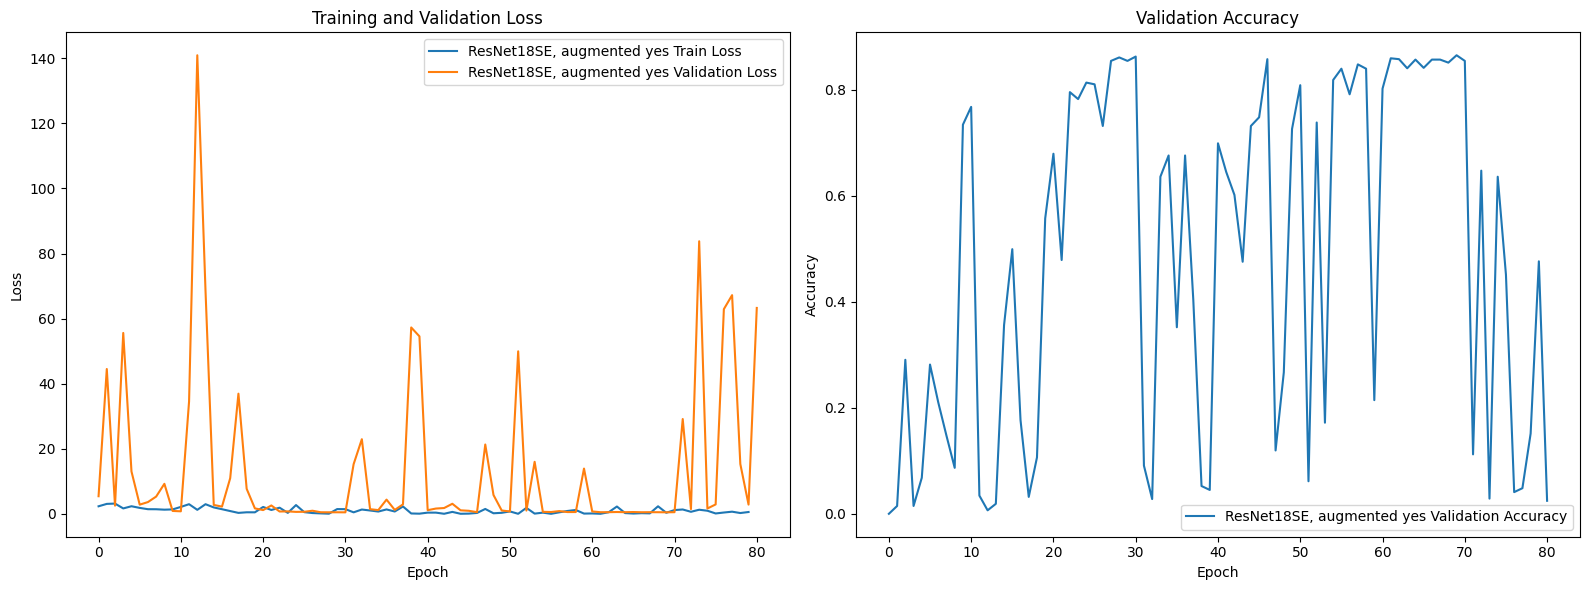

In [25]:
cnn_aug_df2 = results_df[results_df['Model'] == model.__class__.__name__]
print_val_accuracy_loss_epoch(cnn_aug_df2)
plot_results(cnn_aug_df2)

# Task 4: Use Pre-trained CNN.

### Convert Images to RGB

In [26]:
augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.2)),
    transforms.RandomRotation(degrees=(-15, 15)),  # Reduced rotation
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Reduced translation
    transforms.RandomPerspective(distortion_scale=0.05, p=0.2),  # Reduced distortion
    transforms.RandomErasing(p=0.1),  # Reduced probability of erasing or removed
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])


base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])


val_dataset.dataset.transform = base
test_dataset.dataset.transform = base
train_dataset.transform = augment_transform

### Training

In [27]:
import torch
from torchvision import models
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import os

class ResNet18SETransfer(BaseCNN):
    def __init__(self, num_classes, learning_rate):
        super().__init__(learning_rate, num_classes=num_classes)
        
        # Initialize ResNet18 without pre-trained weights (trained from scratch)
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Apply SE block modification to ResNet18
        self.model = self._add_se_block(self.model)
        
        # Replace the final classifier layer for the number of classes in your task
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)
        
    def _add_se_block(self, model):
        """Add SE Block to the model"""
        from torch import nn
        from torch.nn import functional as F

        class SELayer(nn.Module):
            def __init__(self, channel, reduction=16):
                super(SELayer, self).__init__()
                self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
                self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
                self.sigmoid = nn.Sigmoid()

            def forward(self, x):
                b, c, _, _ = x.size()
                y = F.adaptive_avg_pool2d(x, (1, 1))
                y = y.view(b, c)
                y = self.fc2(F.relu(self.fc1(y)))
                y = self.sigmoid(y).view(b, c, 1, 1)
                return x * y

        # Apply SE block to all ResNet blocks
        for name, module in model.named_children():
            if isinstance(module, nn.Sequential):
                for sub_name, sub_module in module.named_children():
                    if isinstance(sub_module, nn.Conv2d):
                        module.add_module(f'se_{sub_name}', SELayer(sub_module.out_channels))
        
        return model

    def forward(self, x):
        x = self.model(x)  # Forward pass through ResNet-18 with SE layers
        return x

model = ResNet18SETransfer(num_classes=num_classes, learning_rate=learning_rate)
model, trainer, metrics_logger = train_model(model, train_loader, val_loader, max_epochs=max_epochs, early_stopping_patience=patience)
results_df = add_results(model, trainer, metrics_logger, train_loader, val_loader, test_loader, augmented='yes')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\User\Documents\BZU\Vision\Final_Project\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | loss_fn  | CrossEntropyLoss   | 0      | train
1 | accuracy | MulticlassAccuracy | 0      | train
2 | model    | ResNet             | 11.2 M | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 90/90 [00:09<00:00,  9.55it/s, v_num=27]         

Metric val_loss improved. New best score: 7.428
Epoch 0, global step 90: 'val_loss' reached 7.42848 (best 7.42848), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v18.ckpt' as top 1


Epoch 1: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=27]

Epoch 1, global step 180: 'val_loss' was not in top 1


Epoch 2: 100%|██████████| 90/90 [00:09<00:00,  9.84it/s, v_num=27]

Metric val_loss improved by 1.472 >= min_delta = 0.001. New best score: 5.956
Epoch 2, global step 270: 'val_loss' reached 5.95608 (best 5.95608), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v18.ckpt' as top 1


Epoch 3: 100%|██████████| 90/90 [00:09<00:00,  9.94it/s, v_num=27]

Metric val_loss improved by 2.911 >= min_delta = 0.001. New best score: 3.045
Epoch 3, global step 360: 'val_loss' reached 3.04467 (best 3.04467), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v18.ckpt' as top 1


Epoch 4: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Metric val_loss improved by 2.088 >= min_delta = 0.001. New best score: 0.956
Epoch 4, global step 450: 'val_loss' reached 0.95643 (best 0.95643), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v18.ckpt' as top 1


Epoch 5: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Epoch 5, global step 540: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=27]

Metric val_loss improved by 0.708 >= min_delta = 0.001. New best score: 0.249
Epoch 6, global step 630: 'val_loss' reached 0.24863 (best 0.24863), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v18.ckpt' as top 1


Epoch 7: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=27]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.242
Epoch 7, global step 720: 'val_loss' reached 0.24158 (best 0.24158), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v18.ckpt' as top 1


Epoch 8: 100%|██████████| 90/90 [00:09<00:00,  9.86it/s, v_num=27]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.237
Epoch 8, global step 810: 'val_loss' reached 0.23731 (best 0.23731), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v18.ckpt' as top 1


Epoch 9: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=27]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.229
Epoch 9, global step 900: 'val_loss' reached 0.22890 (best 0.22890), saving model to 'C:\\Users\\User\\Documents\\BZU\\Vision\\Final_Project\\checkpoints\\best-model-v18.ckpt' as top 1


Epoch 10: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=27]

Epoch 10, global step 990: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=27]

Epoch 11, global step 1080: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=27]

Epoch 12, global step 1170: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=27]

Epoch 13, global step 1260: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=27]

Epoch 14, global step 1350: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Epoch 15, global step 1440: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Epoch 16, global step 1530: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Epoch 17, global step 1620: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 90/90 [00:09<00:00,  9.90it/s, v_num=27]

Epoch 18, global step 1710: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 90/90 [00:09<00:00,  9.90it/s, v_num=27]

Epoch 19, global step 1800: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=27]

Epoch 20, global step 1890: 'val_loss' was not in top 1


Epoch 21: 100%|██████████| 90/90 [00:09<00:00,  9.85it/s, v_num=27]

Epoch 21, global step 1980: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=27]

Epoch 22, global step 2070: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=27]

Epoch 23, global step 2160: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 90/90 [00:09<00:00,  9.90it/s, v_num=27]

Epoch 24, global step 2250: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 90/90 [00:09<00:00,  9.90it/s, v_num=27]

Epoch 25, global step 2340: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=27]

Epoch 26, global step 2430: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 90/90 [00:09<00:00,  9.91it/s, v_num=27]

Epoch 27, global step 2520: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 90/90 [00:09<00:00,  9.90it/s, v_num=27]

Epoch 28, global step 2610: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Epoch 29, global step 2700: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 90/90 [00:09<00:00,  9.90it/s, v_num=27]

Epoch 30, global step 2790: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Epoch 31, global step 2880: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 90/90 [00:09<00:00,  9.90it/s, v_num=27]

Epoch 32, global step 2970: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 90/90 [00:09<00:00,  9.93it/s, v_num=27]

Epoch 33, global step 3060: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 90/90 [00:09<00:00,  9.90it/s, v_num=27]

Epoch 34, global step 3150: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 90/90 [00:09<00:00,  9.91it/s, v_num=27]

Epoch 35, global step 3240: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Epoch 36, global step 3330: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=27]

Epoch 37, global step 3420: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 90/90 [00:09<00:00,  9.90it/s, v_num=27]

Epoch 38, global step 3510: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=27]

Epoch 39, global step 3600: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Epoch 40, global step 3690: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Epoch 41, global step 3780: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 90/90 [00:09<00:00,  9.91it/s, v_num=27]

Epoch 42, global step 3870: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Epoch 43, global step 3960: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Epoch 44, global step 4050: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Epoch 45, global step 4140: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Epoch 46, global step 4230: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 90/90 [00:09<00:00,  9.90it/s, v_num=27]

Epoch 47, global step 4320: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=27]

Epoch 48, global step 4410: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=27]

Epoch 49, global step 4500: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Epoch 50, global step 4590: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=27]

Epoch 51, global step 4680: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Epoch 52, global step 4770: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 90/90 [00:09<00:00,  9.90it/s, v_num=27]

Epoch 53, global step 4860: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=27]

Epoch 54, global step 4950: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 90/90 [00:09<00:00,  9.87it/s, v_num=27]

Epoch 55, global step 5040: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 90/90 [00:09<00:00,  9.88it/s, v_num=27]

Epoch 56, global step 5130: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 90/90 [00:09<00:00,  9.90it/s, v_num=27]

Epoch 57, global step 5220: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 90/90 [00:09<00:00,  9.91it/s, v_num=27]

Epoch 58, global step 5310: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]

Monitored metric val_loss did not improve in the last 50 records. Best score: 0.229. Signaling Trainer to stop.
Epoch 59, global step 5400: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 90/90 [00:09<00:00,  9.89it/s, v_num=27]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing DataLoader 0: 100%|██████████| 90/90 [00:04<00:00, 21.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    1.0
        test_loss          0.0037120571359992027
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:01<00:00, 19.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9345335364341736
        test_loss           0.22890053689479828
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:01<00:00, 18.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9336609244346619
        test_loss           0.23456481099128723
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Get CNN Results

Best Validation Accuracy: 0.9345 at epoch 10, Validation Loss: 0.2373


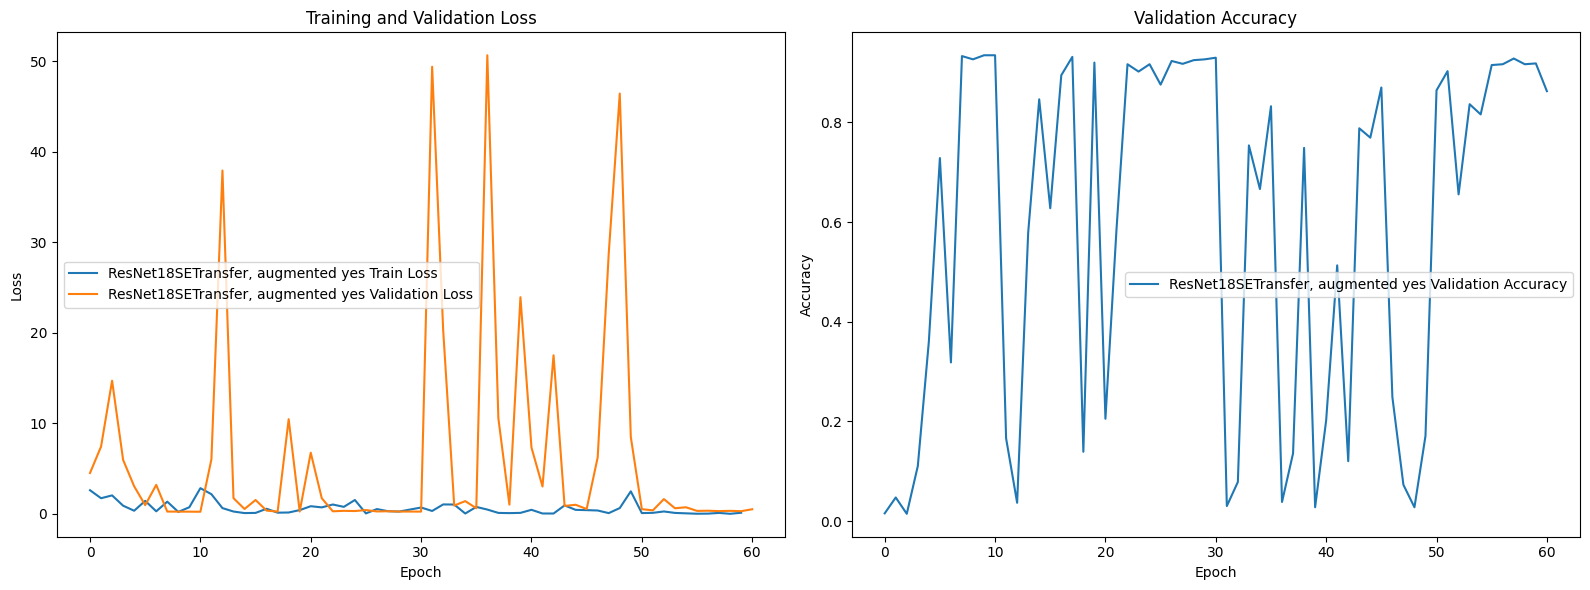

In [28]:
cnn_aug_df3 = results_df[results_df['Model'] == model.__class__.__name__]
print_val_accuracy_loss_epoch(cnn_aug_df3)
plot_results(cnn_aug_df3)

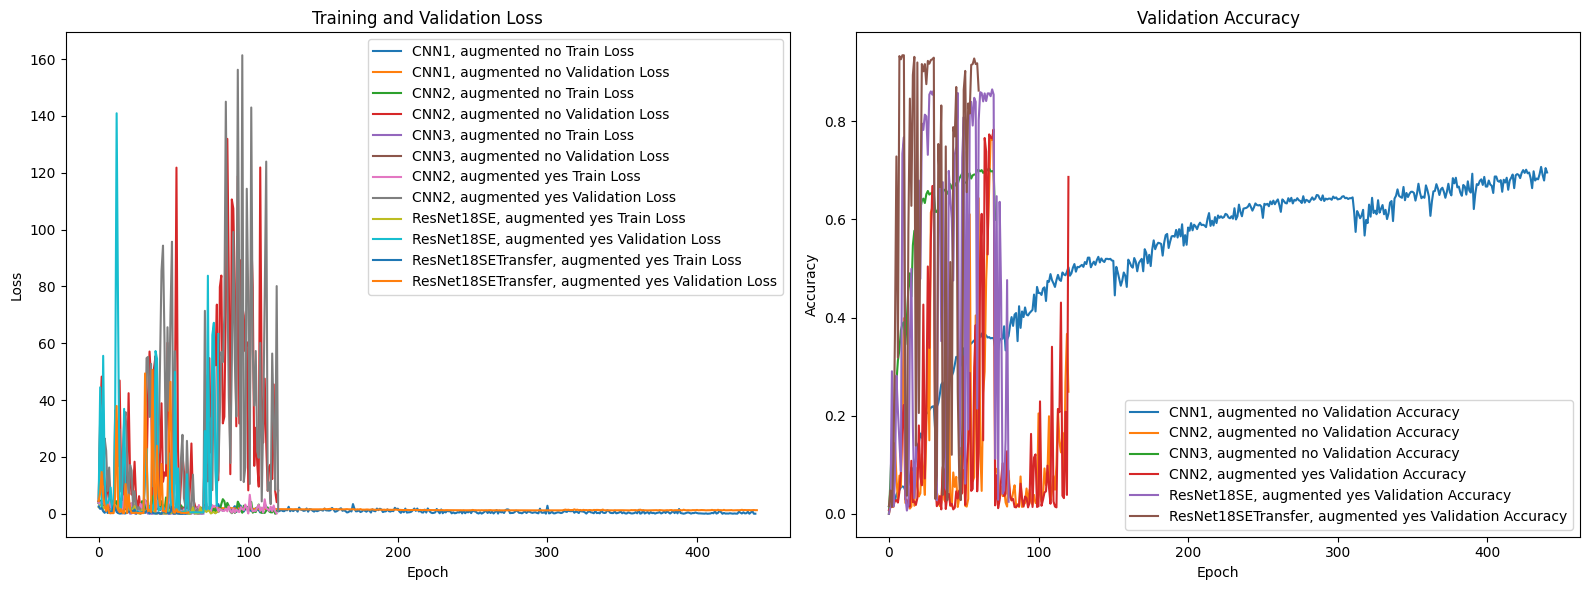

In [29]:
plot_results(results_df)

In [30]:
results_df

,Model,Train Loss List,Validation Loss List,Validation Accuracy List,Train Accuracy,Validation Accuracy,Test Accuracy,Augmented
0,CNN1,"[4.294394493103027, 4.209037780761719, 3.72632...","[4.405345916748047, 4.119607925415039, 3.91600...","[0.015625, 0.023731587454676628, 0.03191489353...",0.904754,0.693126,0.683866,no
1,CNN2,"[3.6540675163269043, 4.650341987609863, 3.9312...","[4.408320426940918, 34.23318099975586, 48.2757...","[0.0, 0.01391162071377039, 0.01472995057702064...",0.922996,0.783142,0.809173,no
2,CNN3,"[3.7663676738739014, 4.131963729858398, 3.6419...","[4.40950870513916, 3.7784841060638428, 3.35171...","[0.0, 0.06873977184295654, 0.14975449442863464...",0.947553,0.622750,0.611794,no
3,CNN2,"[3.976802110671997, 3.546243190765381, 4.16490...","[4.407951831817627, 30.817228317260742, 33.075...","[0.0078125, 0.01391162071377039, 0.01472995057...",0.927732,0.783142,0.793612,yes
4,ResNet18SE,"[2.319122314453125, 3.0550575256347656, 3.1529...","[5.4108076095581055, 44.515201568603516, 2.511...","[0.0, 0.014729950577020645, 0.2905073761940002...",1.000000,0.862520,0.855037,yes
5,ResNet18SETransfer,"[2.606750011444092, 1.7229713201522827, 2.0361...","[4.511382102966309, 7.428481578826904, 14.7090...","[0.015625, 0.047463174909353256, 0.01472995057...",1.000000,0.934534,0.933661,yes


# Plot Best Validation Accuracy of each CNN

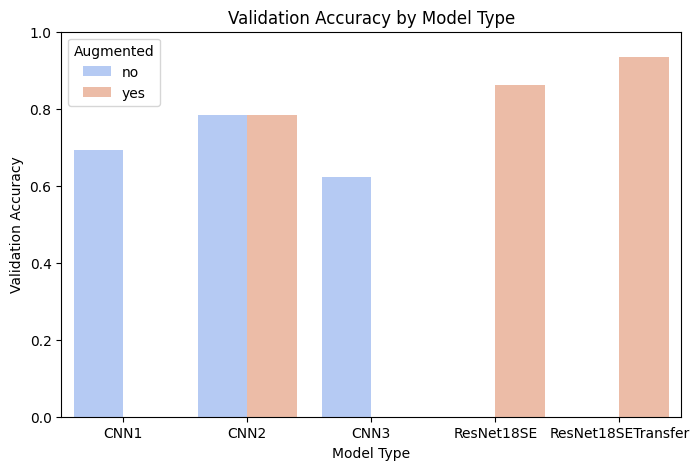

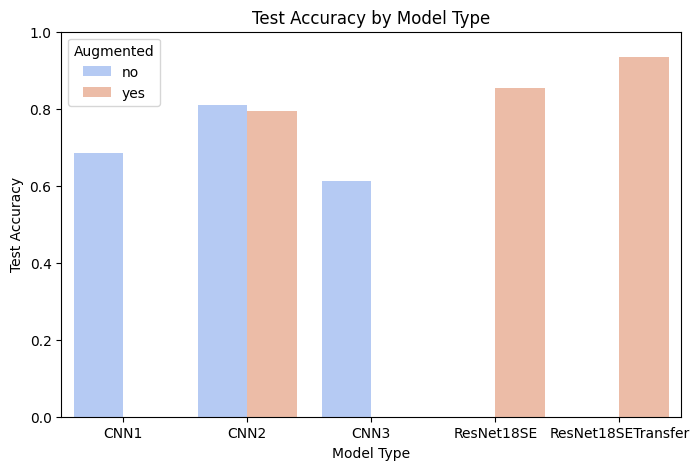

In [31]:
def barplot_accuracy(df, accuracy_type="Validation Accuracy"):
    # Bar plot for accuracy
    plt.figure(figsize=(8, 5))
    sns.barplot(x="Model", y=accuracy_type, hue="Augmented", data=df, palette="coolwarm")
    plt.title(accuracy_type + " by Model Type")
    plt.xlabel("Model Type")
    plt.ylabel(accuracy_type)
    plt.ylim(0, 1)
    plt.legend(title="Augmented")
    plt.show()

barplot_accuracy(results_df, accuracy_type="Validation Accuracy")
barplot_accuracy(results_df, accuracy_type="Test Accuracy")

In [35]:
latex_table = results_df[['Model', 'Train Accuracy', 'Validation Accuracy', 'Test Accuracy', 'Augmented']].to_latex(index=False)
print(latex_table)

\begin{tabular}{lrrrl}
\toprule
Model & Train Accuracy & Validation Accuracy & Test Accuracy & Augmented \\
\midrule
CNN1 & 0.904754 & 0.693126 & 0.683866 & no \\
CNN2 & 0.922996 & 0.783142 & 0.809173 & no \\
CNN3 & 0.947553 & 0.622750 & 0.611794 & no \\
CNN2 & 0.927732 & 0.783142 & 0.793612 & yes \\
ResNet18SE & 1.000000 & 0.862520 & 0.855037 & yes \\
ResNet18SETransfer & 1.000000 & 0.934534 & 0.933661 & yes \\
\bottomrule
\end{tabular}

